In [1]:
using DelimitedFiles
using Random
using Statistics
using Printf
include("func.jl");
include("agentSEIR.jl");

In [2]:
using PyCall, PyPlot
plt = pyimport("matplotlib.pyplot");

# Read Data

In [3]:
# Load graph data
contact_degree = Int[]
open("data/montreal/montreal_degree.txt") do io
    for s in eachline(io)
        push!(contact_degree, Int(parse(Float64,s)))
    end
end
contacts = Int[]
open("data/montreal/montreal_contacts.txt") do io
    for s in eachline(io)
        push!(contacts, Int(parse(Float64,s)))
    end
end

n = length(contact_degree)
end_ = cumsum(contact_degree)
beg_ = vcat(0, end_[1:n-1])
beg_ .+= 1
ll = [contacts[i:j] for (i,j) in zip(beg_, end_)]
end_ = nothing
beg_ = nothing
contacts = nothing
GC.gc()

degree = Int[length(ll[i]) for i in 1:n]
m = Int(sum(degree)/2)
edges = get_edges(ll, n, m);

In [4]:
# Load pre-computed betweenness measures
sp = vec(readdlm("data/montreal/montreal_shortest_path_betweenness.txt"));
eg = vec(readdlm("data/montreal/montreal_eigenvector_centrality.txt"));
local02 = vec(readdlm("data/montreal/montreal_local02_betweenness.txt"));
local04 = vec(readdlm("data/montreal/montreal_local04_betweenness.txt"));
local10 = vec(readdlm("data/montreal/montreal_local10_betweenness.txt"));
local25 = vec(readdlm("data/montreal/montreal_local25_betweenness.txt"));

# Intervention and simulation results

In [5]:
init_infectious = vec(readdlm("data/montreal/montreal_initial_cluster.txt", '\t', Int, '\n'));

In [6]:
edge_to_loc = Dict{Tuple{Int,Int},Int}()
for i in 1:length(ll)
    for (loc,j) in enumerate(ll[i])
        edge_to_loc[(i,j)] = loc
    end
end

## Scenario 1: $\beta$ is set to correspond to $R_0 = 2.5$

In [7]:
# Verify that beta is set appropriately
t_end = 100
_, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_end, beta=0.36)
println("This should be around 0.89: ", sum_R[t_end+1]/n)

This should be around 0.89: 0.8925308194343727


In [8]:
perc = .25;
reduced_weight = .1;

In [9]:
lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, descending=true, weight=reduced_weight);
lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
lw_sp = get_list_of_weights(ll, edges, sp, edge_to_loc, perc, weight=reduced_weight);
lw_lf10 = get_list_of_weights(ll, edges, local10, edge_to_loc, perc, weight=reduced_weight);
lw_lf04 = get_list_of_weights(ll, edges, local04, edge_to_loc, perc, weight=reduced_weight);
lw_lf02 = get_list_of_weights(ll, edges, local02, edge_to_loc, perc, weight=reduced_weight);

#### Predicted epidemic curves: random initialization, no delay, 25% intervention

In [10]:
t_end = 50

init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

_, sum_S_ni, sum_E_ni, sum_I_ni, sum_R_ni = agentSEIR(ll, days=t_end, beta=0.36, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_ui, sum_E_ui, sum_I_ui, sum_R_ui = agentSEIR(ll, days=t_end, beta=0.36, weighted=true, lw=lw_ui, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_hd, sum_E_hd, sum_I_hd, sum_R_hd = agentSEIR(ll, days=t_end, beta=0.36, weighted=true, lw=lw_hd, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_eg, sum_E_eg, sum_I_eg, sum_R_eg = agentSEIR(ll, days=t_end, beta=0.36, weighted=true, lw=lw_eg, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_sp, sum_E_sp, sum_I_sp, sum_R_sp = agentSEIR(ll, days=t_end, beta=0.36, weighted=true, lw=lw_sp, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_lf10, sum_E_lf10, sum_I_lf10, sum_R_lf10 = agentSEIR(ll, days=t_end, beta=0.36, weighted=true, lw=lw_lf10, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_lf04, sum_E_lf04, sum_I_lf04, sum_R_lf04 = agentSEIR(ll, days=t_end, beta=0.36, weighted=true, lw=lw_lf04, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_lf02, sum_E_lf02, sum_I_lf02, sum_R_lf02 = agentSEIR(ll, days=t_end, beta=0.36, weighted=true, lw=lw_lf02, rand_init=false, init_infectious_nodes=init_rand_infectious);

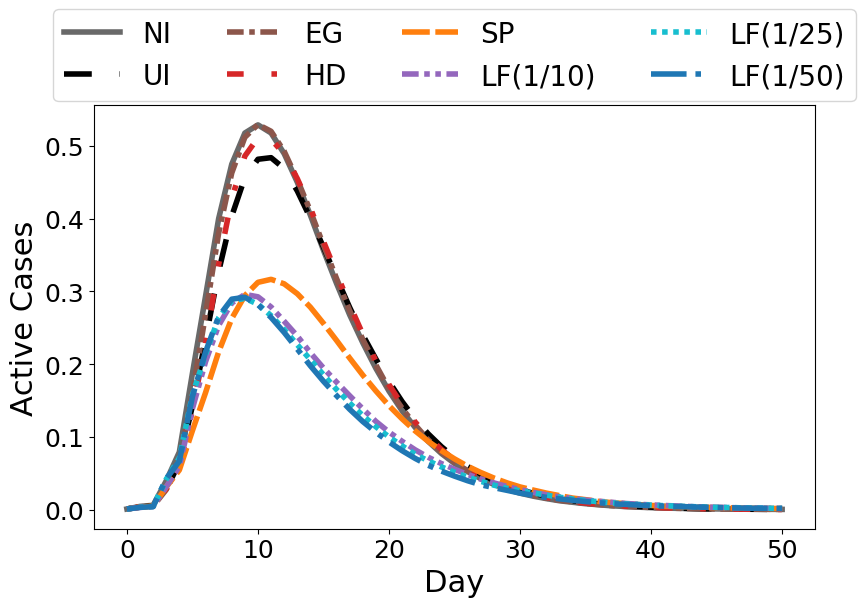

In [11]:
t_int = [i for i in 0:t_end]

plt.figure(figsize=(9.3,5.5))
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label="NI", linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label="UI", linestyle=(0,(5,5)), color="k", linewidth=4)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_sp+sum_I_sp)/n, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf10+sum_I_lf10)/n, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf04+sum_I_lf04)/n, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf02+sum_I_lf02)/n, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Day", fontsize=22)
plt.ylabel("Active Cases", fontsize=22)
plt.savefig("montreal_curves_randinit_R025.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

#### Predicted epidemic curves: random initialization, delay = 5 days, 25% intervention

In [12]:
t_end = 50
t_delay = 5
t_con = t_end - t_delay

init_state, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.36);
_, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.36, rand_init=false, init_state=init_state);
_, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.36, weighted=true, lw=lw_ui, rand_init=false, init_state=init_state);
_, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.36, weighted=true, lw=lw_hd, rand_init=false, init_state=init_state);
_, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.36, weighted=true, lw=lw_eg, rand_init=false, init_state=init_state);
_, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_con, beta=0.36, weighted=true, lw=lw_sp, rand_init=false, init_state=init_state);
_, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_con, beta=0.36, weighted=true, lw=lw_lf10, rand_init=false, init_state=init_state);
_, _, sum_E_lf04, sum_I_lf04, sum_R_lf04 = Main.agentSEIR(ll, days=t_con, beta=0.36, weighted=true, lw=lw_lf04, rand_init=false, init_state=init_state);
_, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_con, beta=0.36, weighted=true, lw=lw_lf02, rand_init=false, init_state=init_state);

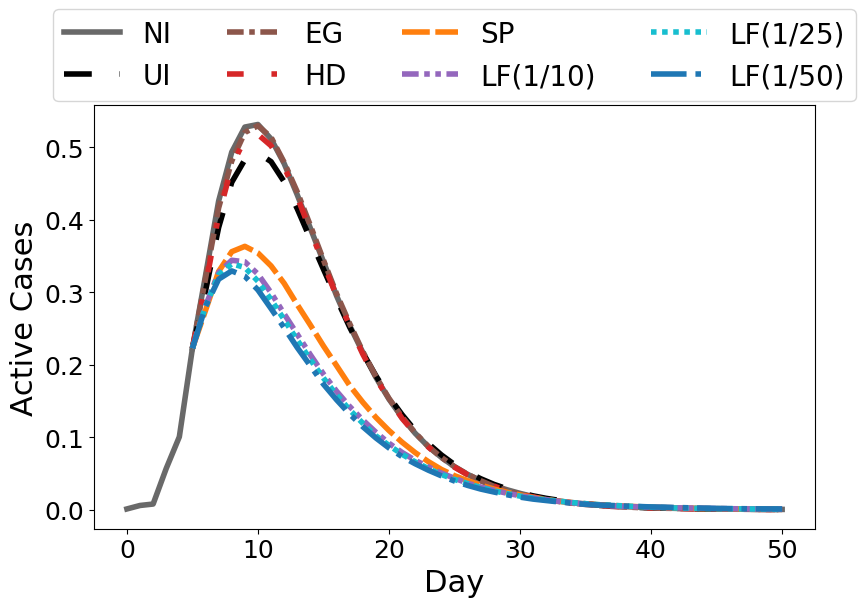

In [13]:
t_ini = [i for i in 0:t_delay]
t_int = [i for i in t_delay:t_end]

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini, (sum_E+sum_I)/n, linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label="NI", linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label="UI", linestyle=(0,(5,5)), color="k", linewidth=4)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_sp+sum_I_sp)/n, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf10+sum_I_lf10)/n, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf04+sum_I_lf04)/n, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf02+sum_I_lf02)/n, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Day", fontsize=22)
plt.ylabel("Active Cases", fontsize=22)
plt.savefig("montreal_curves_randinit_R025_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

### Simulation for interventions that start on day 0

In [14]:
reduced_weight = .1;
t_end = 150;
target_perc = Float64[5.0e-2,.1,.15,.2,.25,.3,.35,.4,.45,.5];

num_scenarios = length(target_perc);
num_trials = 20;

maxCases_ni = zeros(Int, (num_trials,num_scenarios));
maxCases_ui = zeros(Int, (num_trials,num_scenarios));
maxCases_hd = zeros(Int, (num_trials,num_scenarios));
maxCases_eg = zeros(Int, (num_trials,num_scenarios));
maxCases_sp = zeros(Int, (num_trials,num_scenarios));
maxCases_lf10 = zeros(Int, (num_trials,num_scenarios));
maxCases_lf04 = zeros(Int, (num_trials,num_scenarios));
maxCases_lf02 = zeros(Int, (num_trials,num_scenarios));
totalCases_ni = zeros(Int, (num_trials,num_scenarios));
totalCases_ui = zeros(Int, (num_trials,num_scenarios));
totalCases_hd = zeros(Int, (num_trials,num_scenarios));
totalCases_eg = zeros(Int, (num_trials,num_scenarios));
totalCases_sp = zeros(Int, (num_trials,num_scenarios));
totalCases_lf10 = zeros(Int, (num_trials,num_scenarios));
totalCases_lf04 = zeros(Int, (num_trials,num_scenarios));
totalCases_lf02 = zeros(Int, (num_trials,num_scenarios));

for k in 1:num_scenarios
    
    perc = target_perc[k];
    
    lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
    lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, descending=true, weight=reduced_weight);
    lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
    lw_sp = get_list_of_weights(ll, edges, sp, edge_to_loc, perc, weight=reduced_weight);
    lw_lf10 = get_list_of_weights(ll, edges, local10, edge_to_loc, perc, weight=reduced_weight);
    lw_lf04 = get_list_of_weights(ll, edges, local04, edge_to_loc, perc, weight=reduced_weight);
    lw_lf02 = get_list_of_weights(ll, edges, local02, edge_to_loc, perc, weight=reduced_weight);
    
    for trial in 1:num_trials
        
        @printf("\rperc %.2f \ttrial %d of %d ", perc, trial, num_trials)
        
        init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

        _, _, sum_E_ni, sum_I_ni, sum_R_ni = agentSEIR(ll, days=t_end, beta=0.36, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = agentSEIR(ll, days=t_end, beta=0.36, weighted=true, lw=lw_ui, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = agentSEIR(ll, days=t_end, beta=0.36, weighted=true, lw=lw_hd, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = agentSEIR(ll, days=t_end, beta=0.36, weighted=true, lw=lw_eg, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _p, sum_E_sp, sum_I_sp, sum_R_sp = agentSEIR(ll, days=t_end, beta=0.36, weighted=true, lw=lw_sp, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = agentSEIR(ll, days=t_end, beta=0.36, weighted=true, lw=lw_lf10, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_lf04, sum_I_lf04, sum_R_lf04 = agentSEIR(ll, days=t_end, beta=0.36, weighted=true, lw=lw_lf04, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = agentSEIR(ll, days=t_end, beta=0.36, weighted=true, lw=lw_lf02, rand_init=false, init_infectious_nodes=init_rand_infectious);
        
        maxCases_ni[trial,k] = maximum(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = maximum(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = maximum(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = maximum(sum_E_eg + sum_I_eg)
        maxCases_sp[trial,k] = maximum(sum_E_sp + sum_I_sp)
        maxCases_lf10[trial,k] = maximum(sum_E_lf10 + sum_I_lf10)
        maxCases_lf04[trial,k] = maximum(sum_E_lf04 + sum_I_lf04)
        maxCases_lf02[trial,k] = maximum(sum_E_lf02 + sum_I_lf02)   
        totalCases_ni[trial,k] = sum_R_ni[t_end+1]
        totalCases_ui[trial,k] = sum_R_ui[t_end+1]
        totalCases_hd[trial,k] = sum_R_hd[t_end+1]
        totalCases_eg[trial,k] = sum_R_eg[t_end+1]
        totalCases_sp[trial,k] = sum_R_sp[t_end+1]
        totalCases_lf10[trial,k] = sum_R_lf10[t_end+1]
        totalCases_lf04[trial,k] = sum_R_lf04[t_end+1]
        totalCases_lf02[trial,k] = sum_R_lf02[t_end+1]
    end
end

perc 0.50 	trial 20 of 20 0.15 	trial 2 of 20 0.15 	trial 4 of 20 0.15 	trial 6 of 20 0.15 	trial 8 of 20 0.15 	trial 10 of 20 0.15 	trial 12 of 20 0.15 	trial 14 of 20 0.15 	trial 16 of 20 0.15 	trial 18 of 20 0.15 	trial 20 of 20 0.25 	trial 2 of 20 0.25 	trial 4 of 20 0.25 	trial 6 of 20 0.25 	trial 8 of 20 0.25 	trial 10 of 20 0.25 	trial 12 of 20 0.25 	trial 14 of 20 0.25 	trial 16 of 20 0.25 	trial 18 of 20 0.25 	trial 20 of 20 0.35 	trial 2 of 20 0.35 	trial 4 of 20 0.35 	trial 6 of 20 0.35 	trial 8 of 20 0.35 	trial 10 of 20 0.35 	trial 12 of 20 0.35 	trial 14 of 20 0.35 	trial 16 of 20 0.35 	trial 18 of 20 0.35 	trial 20 of 20 0.45 	trial 2 of 20 0.45 	trial 4 of 20 0.45 	trial 6 of 20 0.45 	trial 8 of 20 0.45 	trial 10 of 20 0.45 	trial 12 of 20 0.45 	trial 14 of 20 0.45 	trial 16 of 20 0.45 	trial 18 of 20 0.45 	trial 20 of 20 

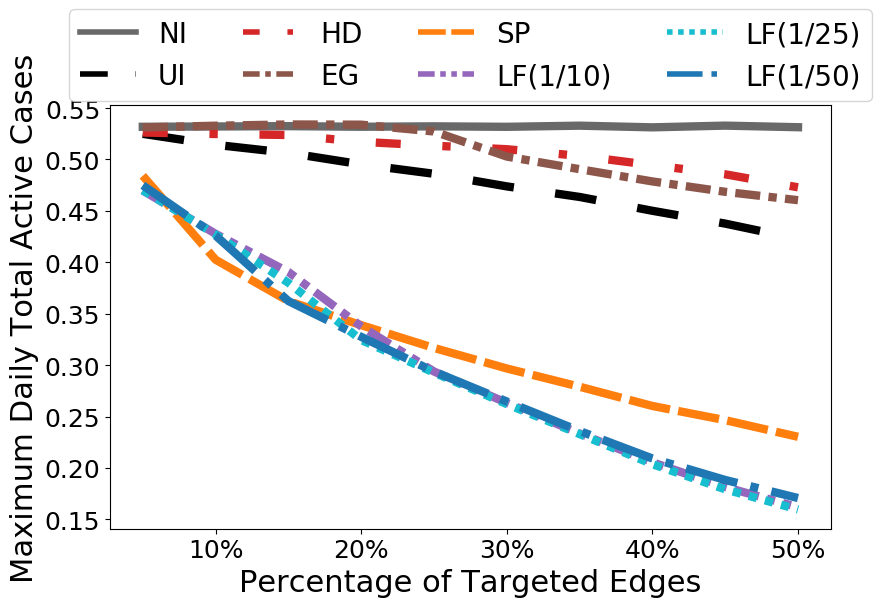

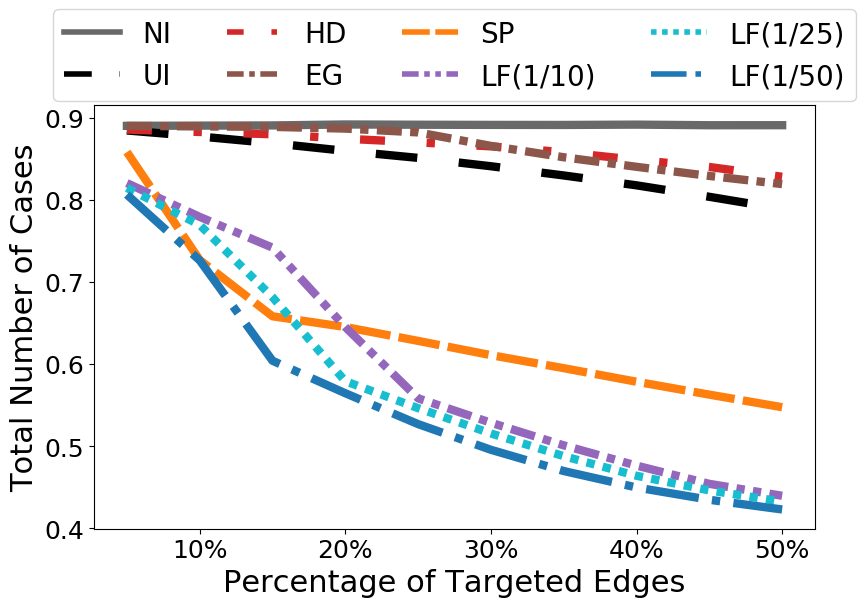

In [15]:
maxCases_ni_mean = vec(mean(maxCases_ni, dims=1))./n;
maxCases_ui_mean = vec(mean(maxCases_ui, dims=1))./n;
maxCases_hd_mean = vec(mean(maxCases_hd, dims=1))./n;
maxCases_eg_mean = vec(mean(maxCases_eg, dims=1))./n;
maxCases_sp_mean = vec(mean(maxCases_sp, dims=1))./n;
maxCases_lf10_mean = vec(mean(maxCases_lf10, dims=1))./n;
maxCases_lf04_mean = vec(mean(maxCases_lf04, dims=1))./n;
maxCases_lf02_mean = vec(mean(maxCases_lf02, dims=1))./n;
totalCases_ni_mean = vec(mean(totalCases_ni, dims=1))./n;
totalCases_ui_mean = vec(mean(totalCases_ui, dims=1))./n;
totalCases_hd_mean = vec(mean(totalCases_hd, dims=1))./n;
totalCases_eg_mean = vec(mean(totalCases_eg, dims=1))./n;
totalCases_sp_mean = vec(mean(totalCases_sp, dims=1))./n;
totalCases_lf10_mean = vec(mean(totalCases_lf10, dims=1))./n;
totalCases_lf04_mean = vec(mean(totalCases_lf04, dims=1))./n;
totalCases_lf02_mean = vec(mean(totalCases_lf02, dims=1))./n;

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=6)
plt.plot(target_perc, maxCases_lf04_mean, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Maximum Daily Total Active Cases",fontsize=22)
plt.savefig("montreal_epipeak_randinit_R025.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=6)
    plt.plot(target_perc, totalCases_lf04_mean, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Total Number of Cases",fontsize=22)
plt.savefig("montreal_episize_randinit_R025.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

### Simulation for interventions that start on day 5

In [16]:
reduced_weight = .1;
target_perc = Float64[5.0e-2,.1,.15,.2,.25,.3,.35,.4,.45,.5];
t_end = 150
t_delay = 5
t_con = t_end - t_delay

num_scenarios = length(target_perc);
num_trials = 20;

maxCases_ni = zeros(Int, (num_trials,num_scenarios));
maxCases_ui = zeros(Int, (num_trials,num_scenarios));
maxCases_hd = zeros(Int, (num_trials,num_scenarios));
maxCases_eg = zeros(Int, (num_trials,num_scenarios));
maxCases_sp = zeros(Int, (num_trials,num_scenarios));
maxCases_lf10 = zeros(Int, (num_trials,num_scenarios));
maxCases_lf04 = zeros(Int, (num_trials,num_scenarios));
maxCases_lf02 = zeros(Int, (num_trials,num_scenarios));
totalCases_ni = zeros(Int, (num_trials,num_scenarios));
totalCases_ui = zeros(Int, (num_trials,num_scenarios));
totalCases_hd = zeros(Int, (num_trials,num_scenarios));
totalCases_eg = zeros(Int, (num_trials,num_scenarios));
totalCases_sp = zeros(Int, (num_trials,num_scenarios));
totalCases_lf10 = zeros(Int, (num_trials,num_scenarios));
totalCases_lf04 = zeros(Int, (num_trials,num_scenarios));
totalCases_lf02 = zeros(Int, (num_trials,num_scenarios));

for k in 1:num_scenarios
    
    perc = target_perc[k];
    
    lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
    lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, descending=true, weight=reduced_weight);
    lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
    lw_sp = get_list_of_weights(ll, edges, sp, edge_to_loc, perc, weight=reduced_weight);
    lw_lf10 = get_list_of_weights(ll, edges, local10, edge_to_loc, perc, weight=reduced_weight);
    lw_lf04 = get_list_of_weights(ll, edges, local04, edge_to_loc, perc, weight=reduced_weight);
    lw_lf02 = get_list_of_weights(ll, edges, local02, edge_to_loc, perc, weight=reduced_weight);
    
    for trial in 1:num_trials
        
        @printf("\rperc %.2f \ttrial %d of %d ", perc, trial, num_trials)
        
        init_state, _, _, _, _ = Main.agentSEIR(ll, days=t_delay, beta=0.36);
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.36, rand_init=false, init_state=init_state);
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.36, weighted=true, lw=lw_ui, rand_init=false, init_state=init_state);
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.36, weighted=true, lw=lw_hd, rand_init=false, init_state=init_state);
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.36, weighted=true, lw=lw_eg, rand_init=false, init_state=init_state);
        _, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_con, beta=0.36, weighted=true, lw=lw_sp, rand_init=false, init_state=init_state);
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_con, beta=0.36, weighted=true, lw=lw_lf10, rand_init=false, init_state=init_state);
        _, _, sum_E_lf04, sum_I_lf04, sum_R_lf04 = Main.agentSEIR(ll, days=t_con, beta=0.36, weighted=true, lw=lw_lf04, rand_init=false, init_state=init_state);
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_con, beta=0.36, weighted=true, lw=lw_lf02, rand_init=false, init_state=init_state);
        
        maxCases_ni[trial,k] = maximum(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = maximum(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = maximum(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = maximum(sum_E_eg + sum_I_eg)
        maxCases_sp[trial,k] = maximum(sum_E_sp + sum_I_sp)
        maxCases_lf10[trial,k] = maximum(sum_E_lf10 + sum_I_lf10)
        maxCases_lf04[trial,k] = maximum(sum_E_lf04 + sum_I_lf04)
        maxCases_lf02[trial,k] = maximum(sum_E_lf02 + sum_I_lf02)   
        totalCases_ni[trial,k] = sum_R_ni[t_con+1]
        totalCases_ui[trial,k] = sum_R_ui[t_con+1]
        totalCases_hd[trial,k] = sum_R_hd[t_con+1]
        totalCases_eg[trial,k] = sum_R_eg[t_con+1]
        totalCases_sp[trial,k] = sum_R_sp[t_con+1]
        totalCases_lf10[trial,k] = sum_R_lf10[t_con+1]
        totalCases_lf04[trial,k] = sum_R_lf04[t_con+1]
        totalCases_lf02[trial,k] = sum_R_lf02[t_con+1]
    end
end

perc 0.50 	trial 20 of 20 0.15 	trial 2 of 20 0.15 	trial 4 of 20 0.15 	trial 6 of 20 0.15 	trial 8 of 20 0.15 	trial 10 of 20 0.15 	trial 12 of 20 0.15 	trial 14 of 20 0.15 	trial 16 of 20 0.15 	trial 18 of 20 0.15 	trial 20 of 20 0.25 	trial 2 of 20 0.25 	trial 4 of 20 0.25 	trial 6 of 20 0.25 	trial 8 of 20 0.25 	trial 10 of 20 0.25 	trial 12 of 20 0.25 	trial 14 of 20 0.25 	trial 16 of 20 0.25 	trial 18 of 20 0.25 	trial 20 of 20 0.35 	trial 2 of 20 0.35 	trial 4 of 20 0.35 	trial 6 of 20 0.35 	trial 8 of 20 0.35 	trial 10 of 20 0.35 	trial 12 of 20 0.35 	trial 14 of 20 0.35 	trial 16 of 20 0.35 	trial 18 of 20 0.35 	trial 20 of 20 0.45 	trial 2 of 20 0.45 	trial 4 of 20 0.45 	trial 6 of 20 0.45 	trial 8 of 20 0.45 	trial 10 of 20 0.45 	trial 12 of 20 0.45 	trial 14 of 20 0.45 	trial 16 of 20 0.45 	trial 18 of 20 0.45 	trial 20 of 20 

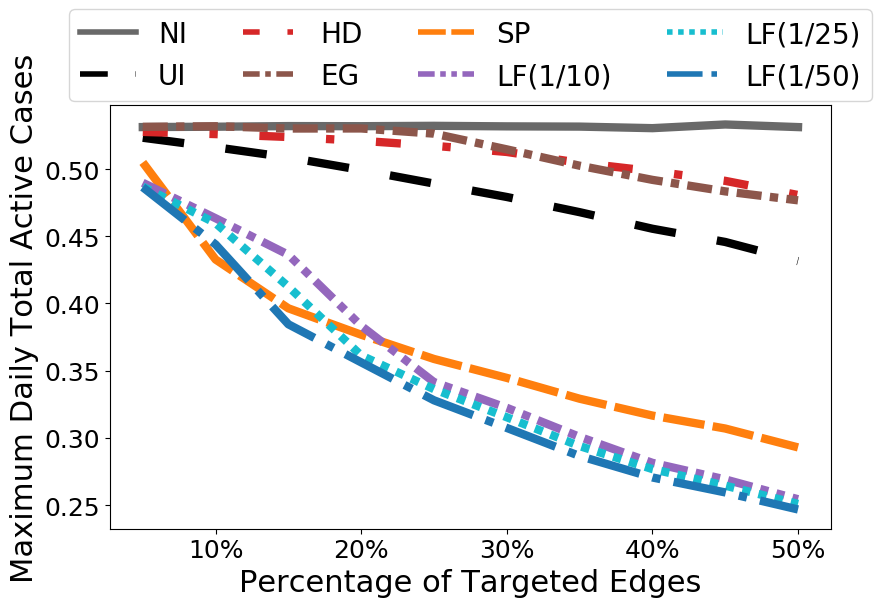

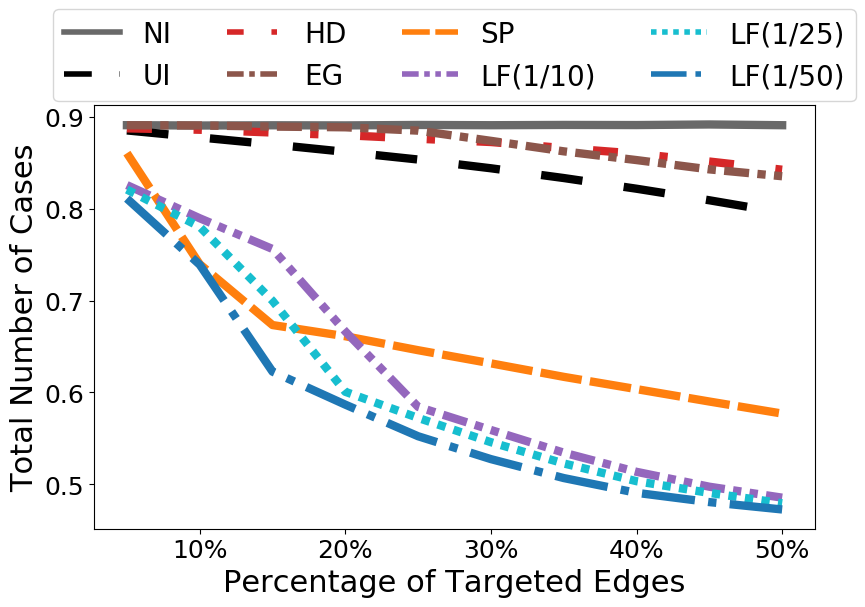

In [17]:
maxCases_ni_mean = vec(mean(maxCases_ni, dims=1))./n;
maxCases_ui_mean = vec(mean(maxCases_ui, dims=1))./n;
maxCases_hd_mean = vec(mean(maxCases_hd, dims=1))./n;
maxCases_eg_mean = vec(mean(maxCases_eg, dims=1))./n;
maxCases_sp_mean = vec(mean(maxCases_sp, dims=1))./n;
maxCases_lf10_mean = vec(mean(maxCases_lf10, dims=1))./n;
maxCases_lf04_mean = vec(mean(maxCases_lf04, dims=1))./n;
maxCases_lf02_mean = vec(mean(maxCases_lf02, dims=1))./n;
totalCases_ni_mean = vec(mean(totalCases_ni, dims=1))./n;
totalCases_ui_mean = vec(mean(totalCases_ui, dims=1))./n;
totalCases_hd_mean = vec(mean(totalCases_hd, dims=1))./n;
totalCases_eg_mean = vec(mean(totalCases_eg, dims=1))./n;
totalCases_sp_mean = vec(mean(totalCases_sp, dims=1))./n;
totalCases_lf10_mean = vec(mean(totalCases_lf10, dims=1))./n;
totalCases_lf04_mean = vec(mean(totalCases_lf04, dims=1))./n;
totalCases_lf02_mean = vec(mean(totalCases_lf02, dims=1))./n;

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=6)
plt.plot(target_perc, maxCases_lf04_mean, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Maximum Daily Total Active Cases",fontsize=22)
plt.savefig("montreal_epipeak_randinit_R025_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=6)
    plt.plot(target_perc, totalCases_lf04_mean, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Total Number of Cases",fontsize=22)
plt.savefig("montreal_episize_randinit_R025_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

## Scenario 2: $\beta$ is set to correspond to $R_0 = 1.5$

In [18]:
# Verify that beta is set appropriately
t_end = 100
_, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_end, beta=0.08)
println("This should be around 0.59: ", sum_R[t_end+1]/n)

This should be around 0.59: 0.5871597776166304


In [19]:
perc = .25;
reduced_weight = .1;

In [20]:
lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, descending=true, weight=reduced_weight);
lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
lw_sp = get_list_of_weights(ll, edges, sp, edge_to_loc, perc, weight=reduced_weight);
lw_lf10 = get_list_of_weights(ll, edges, local10, edge_to_loc, perc, weight=reduced_weight);
lw_lf04 = get_list_of_weights(ll, edges, local04, edge_to_loc, perc, weight=reduced_weight);
lw_lf02 = get_list_of_weights(ll, edges, local02, edge_to_loc, perc, weight=reduced_weight);

#### Predicted epidemic curves: random initialization, no delay, 25% intervention

In [21]:
t_end = 100

init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

_, sum_S_ni, sum_E_ni, sum_I_ni, sum_R_ni = agentSEIR(ll, days=t_end, beta=0.08, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_ui, sum_E_ui, sum_I_ui, sum_R_ui = agentSEIR(ll, days=t_end, beta=0.08, weighted=true, lw=lw_ui, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_hd, sum_E_hd, sum_I_hd, sum_R_hd = agentSEIR(ll, days=t_end, beta=0.08, weighted=true, lw=lw_hd, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_eg, sum_E_eg, sum_I_eg, sum_R_eg = agentSEIR(ll, days=t_end, beta=0.08, weighted=true, lw=lw_eg, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_sp, sum_E_sp, sum_I_sp, sum_R_sp = agentSEIR(ll, days=t_end, beta=0.08, weighted=true, lw=lw_sp, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_lf10, sum_E_lf10, sum_I_lf10, sum_R_lf10 = agentSEIR(ll, days=t_end, beta=0.08, weighted=true, lw=lw_lf10, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_lf04, sum_E_lf04, sum_I_lf04, sum_R_lf04 = agentSEIR(ll, days=t_end, beta=0.08, weighted=true, lw=lw_lf04, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_lf02, sum_E_lf02, sum_I_lf02, sum_R_lf02 = agentSEIR(ll, days=t_end, beta=0.08, weighted=true, lw=lw_lf02, rand_init=false, init_infectious_nodes=init_rand_infectious);

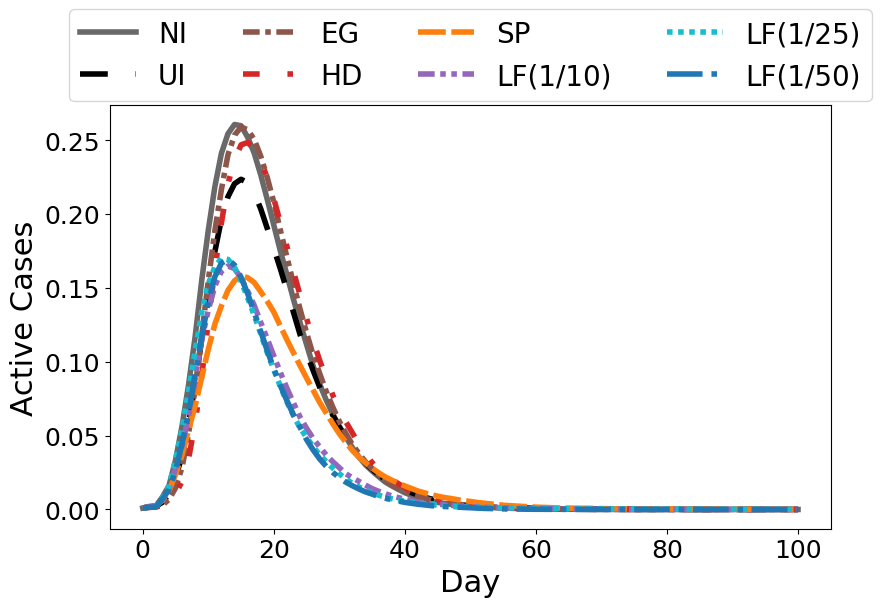

In [22]:
t_int = [i for i in 0:t_end]

plt.figure(figsize=(9.3,5.5))
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label="NI", linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label="UI", linestyle=(0,(5,5)), color="k", linewidth=4)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_sp+sum_I_sp)/n, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf10+sum_I_lf10)/n, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf04+sum_I_lf04)/n, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf02+sum_I_lf02)/n, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Day", fontsize=22)
plt.ylabel("Active Cases", fontsize=22)
plt.savefig("montreal_curves_randinit_R015.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

#### Predicted epidemic curves: random initialization, delay = 5 days, 25% intervention

In [23]:
t_end = 100
t_delay = 5
t_con = t_end - t_delay

init_state, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.08);
_, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.08, rand_init=false, init_state=init_state);
_, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.08, weighted=true, lw=lw_ui, rand_init=false, init_state=init_state);
_, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.08, weighted=true, lw=lw_hd, rand_init=false, init_state=init_state);
_, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.08, weighted=true, lw=lw_eg, rand_init=false, init_state=init_state);
_, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_con, beta=0.08, weighted=true, lw=lw_sp, rand_init=false, init_state=init_state);
_, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_con, beta=0.08, weighted=true, lw=lw_lf10, rand_init=false, init_state=init_state);
_, _, sum_E_lf04, sum_I_lf04, sum_R_lf04 = Main.agentSEIR(ll, days=t_con, beta=0.08, weighted=true, lw=lw_lf04, rand_init=false, init_state=init_state);
_, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_con, beta=0.08, weighted=true, lw=lw_lf02, rand_init=false, init_state=init_state);

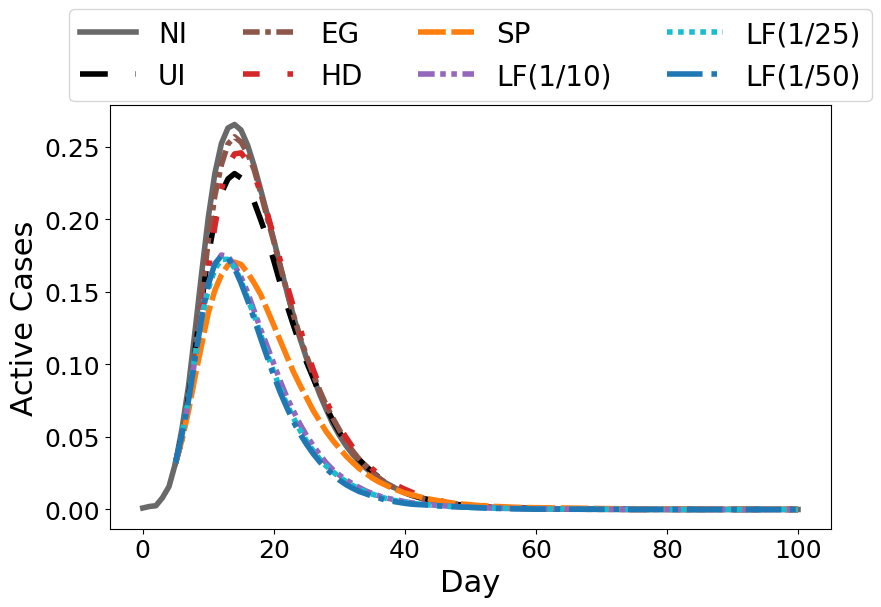

In [24]:
t_ini = [i for i in 0:t_delay]
t_int = [i for i in t_delay:t_end]

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini, (sum_E+sum_I)/n, linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label="NI", linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label="UI", linestyle=(0,(5,5)), color="k", linewidth=4)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_sp+sum_I_sp)/n, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf10+sum_I_lf10)/n, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf04+sum_I_lf04)/n, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf02+sum_I_lf02)/n, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Day", fontsize=22)
plt.ylabel("Active Cases", fontsize=22)
plt.savefig("montreal_curves_randinit_R015_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

### Simulation for interventions that start on day 0

In [25]:
reduced_weight = .1;
t_end = 150;
target_perc = Float64[5.0e-2,.1,.15,.2,.25,.3,.35,.4,.45,.5];

num_scenarios = length(target_perc);
num_trials = 20;

maxCases_ni = zeros(Int, (num_trials,num_scenarios));
maxCases_ui = zeros(Int, (num_trials,num_scenarios));
maxCases_hd = zeros(Int, (num_trials,num_scenarios));
maxCases_eg = zeros(Int, (num_trials,num_scenarios));
maxCases_sp = zeros(Int, (num_trials,num_scenarios));
maxCases_lf10 = zeros(Int, (num_trials,num_scenarios));
maxCases_lf04 = zeros(Int, (num_trials,num_scenarios));
maxCases_lf02 = zeros(Int, (num_trials,num_scenarios));
totalCases_ni = zeros(Int, (num_trials,num_scenarios));
totalCases_ui = zeros(Int, (num_trials,num_scenarios));
totalCases_hd = zeros(Int, (num_trials,num_scenarios));
totalCases_eg = zeros(Int, (num_trials,num_scenarios));
totalCases_sp = zeros(Int, (num_trials,num_scenarios));
totalCases_lf10 = zeros(Int, (num_trials,num_scenarios));
totalCases_lf04 = zeros(Int, (num_trials,num_scenarios));
totalCases_lf02 = zeros(Int, (num_trials,num_scenarios));

for k in 1:num_scenarios
    
    perc = target_perc[k];
    
    lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
    lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, descending=true, weight=reduced_weight);
    lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
    lw_sp = get_list_of_weights(ll, edges, sp, edge_to_loc, perc, weight=reduced_weight);
    lw_lf10 = get_list_of_weights(ll, edges, local10, edge_to_loc, perc, weight=reduced_weight);
    lw_lf04 = get_list_of_weights(ll, edges, local04, edge_to_loc, perc, weight=reduced_weight);
    lw_lf02 = get_list_of_weights(ll, edges, local02, edge_to_loc, perc, weight=reduced_weight);
    
    for trial in 1:num_trials
        
        @printf("\rperc %.2f \ttrial %d of %d ", perc, trial, num_trials)
        
        init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

        _, _, sum_E_ni, sum_I_ni, sum_R_ni = agentSEIR(ll, days=t_end, beta=0.08, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = agentSEIR(ll, days=t_end, beta=0.08, weighted=true, lw=lw_ui, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = agentSEIR(ll, days=t_end, beta=0.08, weighted=true, lw=lw_hd, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = agentSEIR(ll, days=t_end, beta=0.08, weighted=true, lw=lw_eg, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _p, sum_E_sp, sum_I_sp, sum_R_sp = agentSEIR(ll, days=t_end, beta=0.08, weighted=true, lw=lw_sp, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = agentSEIR(ll, days=t_end, beta=0.08, weighted=true, lw=lw_lf10, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_lf04, sum_I_lf04, sum_R_lf04 = agentSEIR(ll, days=t_end, beta=0.08, weighted=true, lw=lw_lf04, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = agentSEIR(ll, days=t_end, beta=0.08, weighted=true, lw=lw_lf02, rand_init=false, init_infectious_nodes=init_rand_infectious);
        
        maxCases_ni[trial,k] = maximum(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = maximum(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = maximum(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = maximum(sum_E_eg + sum_I_eg)
        maxCases_sp[trial,k] = maximum(sum_E_sp + sum_I_sp)
        maxCases_lf10[trial,k] = maximum(sum_E_lf10 + sum_I_lf10)
        maxCases_lf04[trial,k] = maximum(sum_E_lf04 + sum_I_lf04)
        maxCases_lf02[trial,k] = maximum(sum_E_lf02 + sum_I_lf02)   
        totalCases_ni[trial,k] = sum_R_ni[t_end+1]
        totalCases_ui[trial,k] = sum_R_ui[t_end+1]
        totalCases_hd[trial,k] = sum_R_hd[t_end+1]
        totalCases_eg[trial,k] = sum_R_eg[t_end+1]
        totalCases_sp[trial,k] = sum_R_sp[t_end+1]
        totalCases_lf10[trial,k] = sum_R_lf10[t_end+1]
        totalCases_lf04[trial,k] = sum_R_lf04[t_end+1]
        totalCases_lf02[trial,k] = sum_R_lf02[t_end+1]
    end
end

perc 0.50 	trial 20 of 20 0.15 	trial 2 of 20 0.15 	trial 4 of 20 0.15 	trial 6 of 20 0.15 	trial 8 of 20 0.15 	trial 10 of 20 0.15 	trial 12 of 20 0.15 	trial 14 of 20 0.15 	trial 16 of 20 0.15 	trial 18 of 20 0.15 	trial 20 of 20 0.25 	trial 2 of 20 0.25 	trial 4 of 20 0.25 	trial 6 of 20 0.25 	trial 8 of 20 0.25 	trial 10 of 20 0.25 	trial 12 of 20 0.25 	trial 14 of 20 0.25 	trial 16 of 20 0.25 	trial 18 of 20 0.25 	trial 20 of 20 0.35 	trial 2 of 20 0.35 	trial 4 of 20 0.35 	trial 6 of 20 0.35 	trial 8 of 20 0.35 	trial 10 of 20 0.35 	trial 12 of 20 0.35 	trial 14 of 20 0.35 	trial 16 of 20 0.35 	trial 18 of 20 0.35 	trial 20 of 20 0.45 	trial 2 of 20 0.45 	trial 4 of 20 0.45 	trial 6 of 20 0.45 	trial 8 of 20 0.45 	trial 10 of 20 0.45 	trial 12 of 20 0.45 	trial 14 of 20 0.45 	trial 16 of 20 0.45 	trial 18 of 20 0.45 	trial 20 of 20 

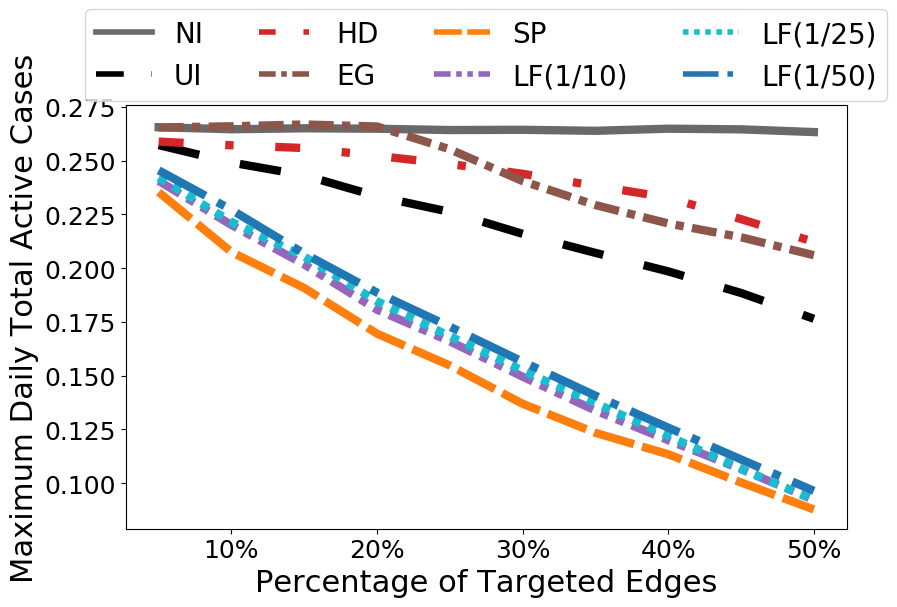

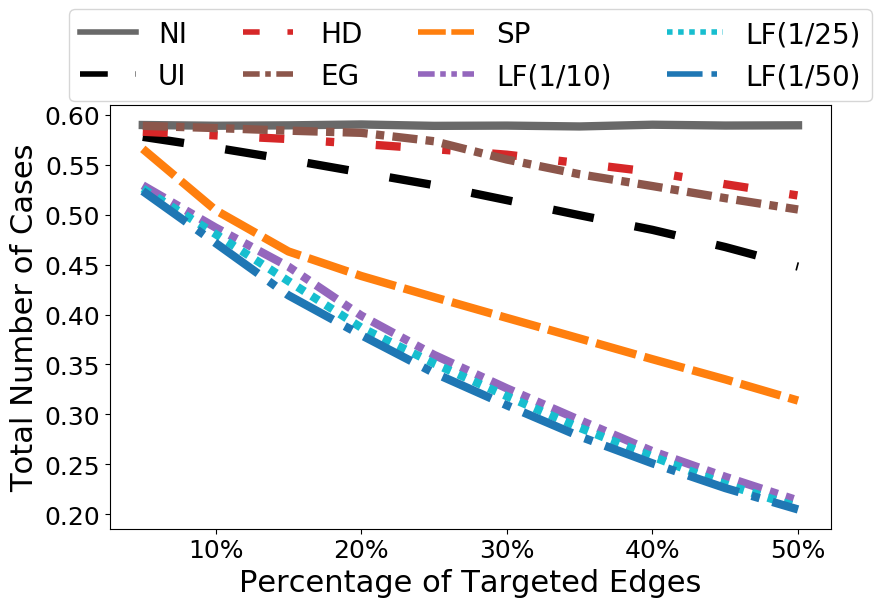

In [26]:
maxCases_ni_mean = vec(mean(maxCases_ni, dims=1))./n;
maxCases_ui_mean = vec(mean(maxCases_ui, dims=1))./n;
maxCases_hd_mean = vec(mean(maxCases_hd, dims=1))./n;
maxCases_eg_mean = vec(mean(maxCases_eg, dims=1))./n;
maxCases_sp_mean = vec(mean(maxCases_sp, dims=1))./n;
maxCases_lf10_mean = vec(mean(maxCases_lf10, dims=1))./n;
maxCases_lf04_mean = vec(mean(maxCases_lf04, dims=1))./n;
maxCases_lf02_mean = vec(mean(maxCases_lf02, dims=1))./n;
totalCases_ni_mean = vec(mean(totalCases_ni, dims=1))./n;
totalCases_ui_mean = vec(mean(totalCases_ui, dims=1))./n;
totalCases_hd_mean = vec(mean(totalCases_hd, dims=1))./n;
totalCases_eg_mean = vec(mean(totalCases_eg, dims=1))./n;
totalCases_sp_mean = vec(mean(totalCases_sp, dims=1))./n;
totalCases_lf10_mean = vec(mean(totalCases_lf10, dims=1))./n;
totalCases_lf04_mean = vec(mean(totalCases_lf04, dims=1))./n;
totalCases_lf02_mean = vec(mean(totalCases_lf02, dims=1))./n;

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=6)
plt.plot(target_perc, maxCases_lf04_mean, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Maximum Daily Total Active Cases",fontsize=22)
plt.savefig("montreal_epipeak_randinit_R015.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=6)
    plt.plot(target_perc, totalCases_lf04_mean, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Total Number of Cases",fontsize=22)
plt.savefig("montreal_episize_randinit_R015.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

### Simulation for interventions that start on day 5

In [27]:
reduced_weight = .1;
target_perc = Float64[5.0e-2,.1,.15,.2,.25,.3,.35,.4,.45,.5];
t_end = 150
t_delay = 5
t_con = t_end - t_delay

num_scenarios = length(target_perc);
num_trials = 20;

maxCases_ni = zeros(Int, (num_trials,num_scenarios));
maxCases_ui = zeros(Int, (num_trials,num_scenarios));
maxCases_hd = zeros(Int, (num_trials,num_scenarios));
maxCases_eg = zeros(Int, (num_trials,num_scenarios));
maxCases_sp = zeros(Int, (num_trials,num_scenarios));
maxCases_lf10 = zeros(Int, (num_trials,num_scenarios));
maxCases_lf04 = zeros(Int, (num_trials,num_scenarios));
maxCases_lf02 = zeros(Int, (num_trials,num_scenarios));
totalCases_ni = zeros(Int, (num_trials,num_scenarios));
totalCases_ui = zeros(Int, (num_trials,num_scenarios));
totalCases_hd = zeros(Int, (num_trials,num_scenarios));
totalCases_eg = zeros(Int, (num_trials,num_scenarios));
totalCases_sp = zeros(Int, (num_trials,num_scenarios));
totalCases_lf10 = zeros(Int, (num_trials,num_scenarios));
totalCases_lf04 = zeros(Int, (num_trials,num_scenarios));
totalCases_lf02 = zeros(Int, (num_trials,num_scenarios));

for k in 1:num_scenarios
    
    perc = target_perc[k];
    
    lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
    lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, descending=true, weight=reduced_weight);
    lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
    lw_sp = get_list_of_weights(ll, edges, sp, edge_to_loc, perc, weight=reduced_weight);
    lw_lf10 = get_list_of_weights(ll, edges, local10, edge_to_loc, perc, weight=reduced_weight);
    lw_lf04 = get_list_of_weights(ll, edges, local04, edge_to_loc, perc, weight=reduced_weight);
    lw_lf02 = get_list_of_weights(ll, edges, local02, edge_to_loc, perc, weight=reduced_weight);
    
    for trial in 1:num_trials
        
        @printf("\rperc %.2f \ttrial %d of %d ", perc, trial, num_trials)
        
        init_state, _, _, _, _ = Main.agentSEIR(ll, days=t_delay, beta=0.08);
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.08, rand_init=false, init_state=init_state);
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.08, weighted=true, lw=lw_ui, rand_init=false, init_state=init_state);
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.08, weighted=true, lw=lw_hd, rand_init=false, init_state=init_state);
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.08, weighted=true, lw=lw_eg, rand_init=false, init_state=init_state);
        _, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_con, beta=0.08, weighted=true, lw=lw_sp, rand_init=false, init_state=init_state);
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_con, beta=0.08, weighted=true, lw=lw_lf10, rand_init=false, init_state=init_state);
        _, _, sum_E_lf04, sum_I_lf04, sum_R_lf04 = Main.agentSEIR(ll, days=t_con, beta=0.08, weighted=true, lw=lw_lf04, rand_init=false, init_state=init_state);
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_con, beta=0.08, weighted=true, lw=lw_lf02, rand_init=false, init_state=init_state);
        
        maxCases_ni[trial,k] = maximum(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = maximum(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = maximum(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = maximum(sum_E_eg + sum_I_eg)
        maxCases_sp[trial,k] = maximum(sum_E_sp + sum_I_sp)
        maxCases_lf10[trial,k] = maximum(sum_E_lf10 + sum_I_lf10)
        maxCases_lf04[trial,k] = maximum(sum_E_lf04 + sum_I_lf04)
        maxCases_lf02[trial,k] = maximum(sum_E_lf02 + sum_I_lf02)   
        totalCases_ni[trial,k] = sum_R_ni[t_con+1]
        totalCases_ui[trial,k] = sum_R_ui[t_con+1]
        totalCases_hd[trial,k] = sum_R_hd[t_con+1]
        totalCases_eg[trial,k] = sum_R_eg[t_con+1]
        totalCases_sp[trial,k] = sum_R_sp[t_con+1]
        totalCases_lf10[trial,k] = sum_R_lf10[t_con+1]
        totalCases_lf04[trial,k] = sum_R_lf04[t_con+1]
        totalCases_lf02[trial,k] = sum_R_lf02[t_con+1]
    end
end

perc 0.50 	trial 20 of 20 0.15 	trial 2 of 20 0.15 	trial 4 of 20 0.15 	trial 6 of 20 0.15 	trial 8 of 20 0.15 	trial 10 of 20 0.15 	trial 12 of 20 0.15 	trial 14 of 20 0.15 	trial 16 of 20 0.15 	trial 18 of 20 0.15 	trial 20 of 20 0.25 	trial 2 of 20 0.25 	trial 4 of 20 0.25 	trial 6 of 20 0.25 	trial 8 of 20 0.25 	trial 10 of 20 0.25 	trial 12 of 20 0.25 	trial 14 of 20 0.25 	trial 16 of 20 0.25 	trial 18 of 20 0.25 	trial 20 of 20 0.35 	trial 2 of 20 0.35 	trial 4 of 20 0.35 	trial 6 of 20 0.35 	trial 8 of 20 0.35 	trial 10 of 20 0.35 	trial 12 of 20 0.35 	trial 14 of 20 0.35 	trial 16 of 20 0.35 	trial 18 of 20 0.35 	trial 20 of 20 0.45 	trial 2 of 20 0.45 	trial 4 of 20 0.45 	trial 6 of 20 0.45 	trial 8 of 20 0.45 	trial 10 of 20 0.45 	trial 12 of 20 0.45 	trial 14 of 20 0.45 	trial 16 of 20 0.45 	trial 18 of 20 0.45 	trial 20 of 20 

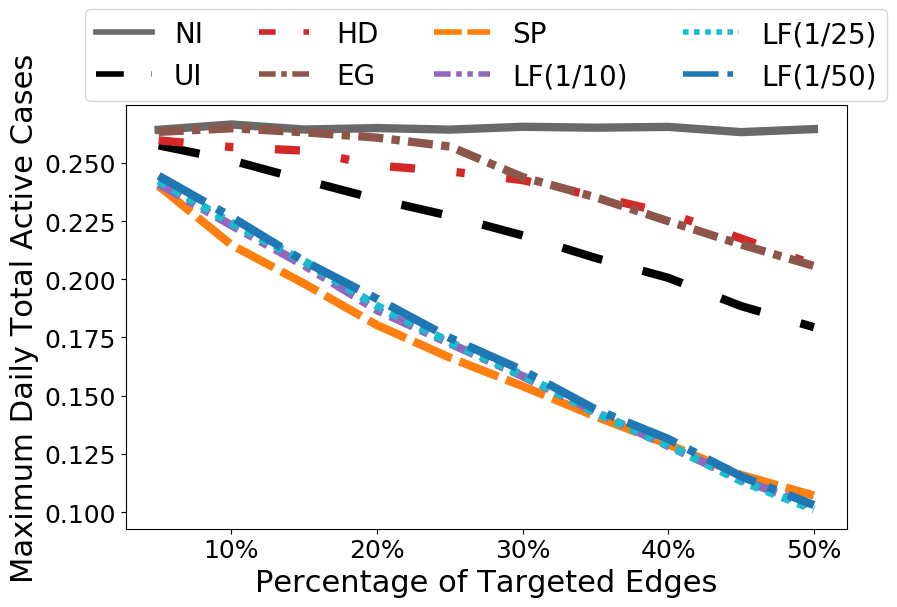

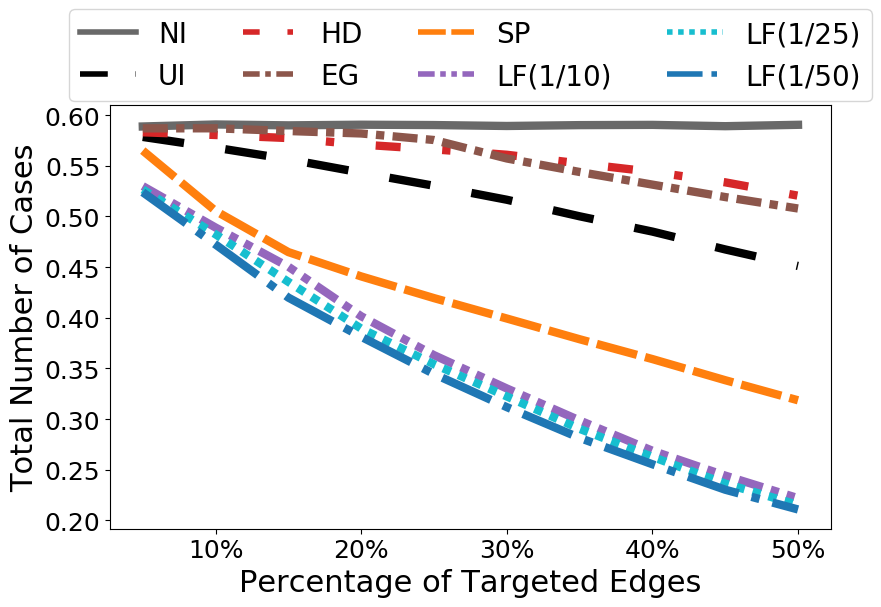

In [28]:
maxCases_ni_mean = vec(mean(maxCases_ni, dims=1))./n;
maxCases_ui_mean = vec(mean(maxCases_ui, dims=1))./n;
maxCases_hd_mean = vec(mean(maxCases_hd, dims=1))./n;
maxCases_eg_mean = vec(mean(maxCases_eg, dims=1))./n;
maxCases_sp_mean = vec(mean(maxCases_sp, dims=1))./n;
maxCases_lf10_mean = vec(mean(maxCases_lf10, dims=1))./n;
maxCases_lf04_mean = vec(mean(maxCases_lf04, dims=1))./n;
maxCases_lf02_mean = vec(mean(maxCases_lf02, dims=1))./n;
totalCases_ni_mean = vec(mean(totalCases_ni, dims=1))./n;
totalCases_ui_mean = vec(mean(totalCases_ui, dims=1))./n;
totalCases_hd_mean = vec(mean(totalCases_hd, dims=1))./n;
totalCases_eg_mean = vec(mean(totalCases_eg, dims=1))./n;
totalCases_sp_mean = vec(mean(totalCases_sp, dims=1))./n;
totalCases_lf10_mean = vec(mean(totalCases_lf10, dims=1))./n;
totalCases_lf04_mean = vec(mean(totalCases_lf04, dims=1))./n;
totalCases_lf02_mean = vec(mean(totalCases_lf02, dims=1))./n;

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=6)
plt.plot(target_perc, maxCases_lf04_mean, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Maximum Daily Total Active Cases",fontsize=22)
plt.savefig("montreal_epipeak_randinit_R015_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=6)
    plt.plot(target_perc, totalCases_lf04_mean, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Total Number of Cases",fontsize=22)
plt.savefig("montreal_episize_randinit_R015_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

## Scenario 3: $\beta$ is set to correspond to $R_0 = 3.5$

In [29]:
# Verify that beta is set appropriately
t_end = 100
_, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_end, beta=0.67)
println("This should be around 0.966: ", sum_R[t_end+1]/n)

This should be around 0.966: 0.9660623640319072


In [30]:
perc = .25;
reduced_weight = .1;

In [31]:
lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, descending=true, weight=reduced_weight);
lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
lw_sp = get_list_of_weights(ll, edges, sp, edge_to_loc, perc, weight=reduced_weight);
lw_lf10 = get_list_of_weights(ll, edges, local10, edge_to_loc, perc, weight=reduced_weight);
lw_lf04 = get_list_of_weights(ll, edges, local04, edge_to_loc, perc, weight=reduced_weight);
lw_lf02 = get_list_of_weights(ll, edges, local02, edge_to_loc, perc, weight=reduced_weight);

#### Predicted epidemic curves: random initialization, no delay, 25% intervention

In [32]:
t_end = 50

init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

_, sum_S_ni, sum_E_ni, sum_I_ni, sum_R_ni = agentSEIR(ll, days=t_end, beta=0.67, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_ui, sum_E_ui, sum_I_ui, sum_R_ui = agentSEIR(ll, days=t_end, beta=0.67, weighted=true, lw=lw_ui, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_hd, sum_E_hd, sum_I_hd, sum_R_hd = agentSEIR(ll, days=t_end, beta=0.67, weighted=true, lw=lw_hd, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_eg, sum_E_eg, sum_I_eg, sum_R_eg = agentSEIR(ll, days=t_end, beta=0.67, weighted=true, lw=lw_eg, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_sp, sum_E_sp, sum_I_sp, sum_R_sp = agentSEIR(ll, days=t_end, beta=0.67, weighted=true, lw=lw_sp, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_lf10, sum_E_lf10, sum_I_lf10, sum_R_lf10 = agentSEIR(ll, days=t_end, beta=0.67, weighted=true, lw=lw_lf10, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_lf04, sum_E_lf04, sum_I_lf04, sum_R_lf04 = agentSEIR(ll, days=t_end, beta=0.67, weighted=true, lw=lw_lf04, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_lf02, sum_E_lf02, sum_I_lf02, sum_R_lf02 = agentSEIR(ll, days=t_end, beta=0.67, weighted=true, lw=lw_lf02, rand_init=false, init_infectious_nodes=init_rand_infectious);

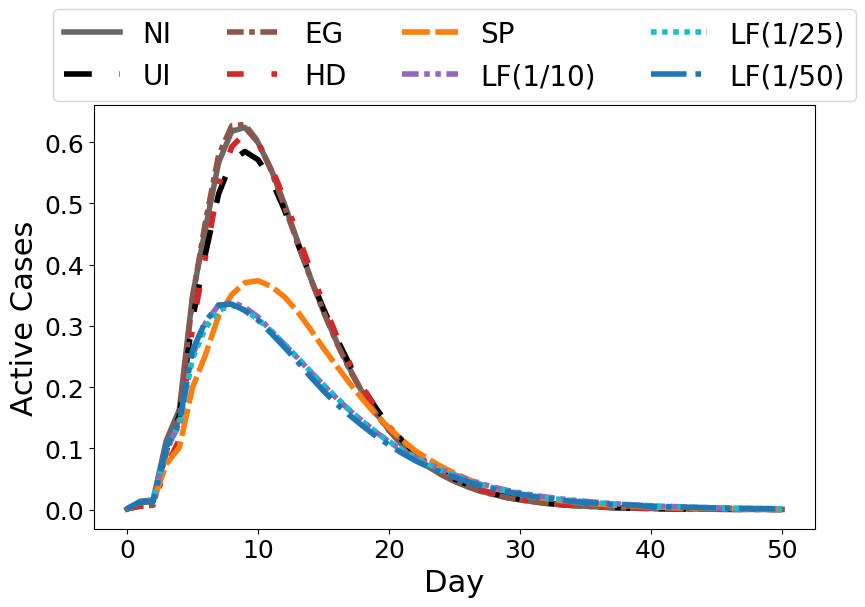

In [33]:
t_int = [i for i in 0:t_end]

plt.figure(figsize=(9.3,5.5))
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label="NI", linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label="UI", linestyle=(0,(5,5)), color="k", linewidth=4)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_sp+sum_I_sp)/n, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf10+sum_I_lf10)/n, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf04+sum_I_lf04)/n, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf02+sum_I_lf02)/n, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Day", fontsize=22)
plt.ylabel("Active Cases", fontsize=22)
plt.savefig("montreal_curves_randinit_R035.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

#### Predicted epidemic curves: random initialization, delay = 5 days, 25% intervention

In [34]:
t_end = 50
t_delay = 5
t_con = t_end - t_delay

init_state, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.67);
_, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.67, rand_init=false, init_state=init_state);
_, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.67, weighted=true, lw=lw_ui, rand_init=false, init_state=init_state);
_, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.67, weighted=true, lw=lw_hd, rand_init=false, init_state=init_state);
_, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.67, weighted=true, lw=lw_eg, rand_init=false, init_state=init_state);
_, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_con, beta=0.67, weighted=true, lw=lw_sp, rand_init=false, init_state=init_state);
_, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_con, beta=0.67, weighted=true, lw=lw_lf10, rand_init=false, init_state=init_state);
_, _, sum_E_lf04, sum_I_lf04, sum_R_lf04 = Main.agentSEIR(ll, days=t_con, beta=0.67, weighted=true, lw=lw_lf04, rand_init=false, init_state=init_state);
_, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_con, beta=0.67, weighted=true, lw=lw_lf02, rand_init=false, init_state=init_state);

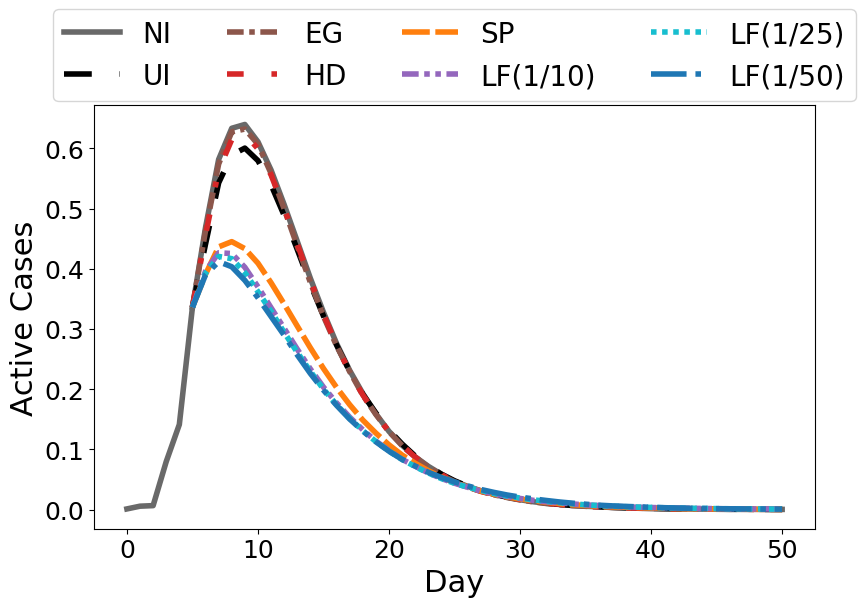

In [35]:
t_ini = [i for i in 0:t_delay]
t_int = [i for i in t_delay:t_end]

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini, (sum_E+sum_I)/n, linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label="NI", linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label="UI", linestyle=(0,(5,5)), color="k", linewidth=4)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_sp+sum_I_sp)/n, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf10+sum_I_lf10)/n, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf04+sum_I_lf04)/n, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf02+sum_I_lf02)/n, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Day", fontsize=22)
plt.ylabel("Active Cases", fontsize=22)
plt.savefig("montreal_curves_randinit_R035_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

### Simulation for interventions that start on day 0

In [36]:
reduced_weight = .1;
t_end = 100;
target_perc = Float64[5.0e-2,.1,.15,.2,.25,.3,.35,.4,.45,.5];

num_scenarios = length(target_perc);
num_trials = 20;

maxCases_ni = zeros(Int, (num_trials,num_scenarios));
maxCases_ui = zeros(Int, (num_trials,num_scenarios));
maxCases_hd = zeros(Int, (num_trials,num_scenarios));
maxCases_eg = zeros(Int, (num_trials,num_scenarios));
maxCases_sp = zeros(Int, (num_trials,num_scenarios));
maxCases_lf10 = zeros(Int, (num_trials,num_scenarios));
maxCases_lf04 = zeros(Int, (num_trials,num_scenarios));
maxCases_lf02 = zeros(Int, (num_trials,num_scenarios));
totalCases_ni = zeros(Int, (num_trials,num_scenarios));
totalCases_ui = zeros(Int, (num_trials,num_scenarios));
totalCases_hd = zeros(Int, (num_trials,num_scenarios));
totalCases_eg = zeros(Int, (num_trials,num_scenarios));
totalCases_sp = zeros(Int, (num_trials,num_scenarios));
totalCases_lf10 = zeros(Int, (num_trials,num_scenarios));
totalCases_lf04 = zeros(Int, (num_trials,num_scenarios));
totalCases_lf02 = zeros(Int, (num_trials,num_scenarios));

for k in 1:num_scenarios
    
    perc = target_perc[k];
    
    lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
    lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, descending=true, weight=reduced_weight);
    lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
    lw_sp = get_list_of_weights(ll, edges, sp, edge_to_loc, perc, weight=reduced_weight);
    lw_lf10 = get_list_of_weights(ll, edges, local10, edge_to_loc, perc, weight=reduced_weight);
    lw_lf04 = get_list_of_weights(ll, edges, local04, edge_to_loc, perc, weight=reduced_weight);
    lw_lf02 = get_list_of_weights(ll, edges, local02, edge_to_loc, perc, weight=reduced_weight);
    
    for trial in 1:num_trials
        
        @printf("\rperc %.2f \ttrial %d of %d ", perc, trial, num_trials)
        
        init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

        _, _, sum_E_ni, sum_I_ni, sum_R_ni = agentSEIR(ll, days=t_end, beta=0.67, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = agentSEIR(ll, days=t_end, beta=0.67, weighted=true, lw=lw_ui, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = agentSEIR(ll, days=t_end, beta=0.67, weighted=true, lw=lw_hd, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = agentSEIR(ll, days=t_end, beta=0.67, weighted=true, lw=lw_eg, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _p, sum_E_sp, sum_I_sp, sum_R_sp = agentSEIR(ll, days=t_end, beta=0.67, weighted=true, lw=lw_sp, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = agentSEIR(ll, days=t_end, beta=0.67, weighted=true, lw=lw_lf10, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_lf04, sum_I_lf04, sum_R_lf04 = agentSEIR(ll, days=t_end, beta=0.67, weighted=true, lw=lw_lf04, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = agentSEIR(ll, days=t_end, beta=0.67, weighted=true, lw=lw_lf02, rand_init=false, init_infectious_nodes=init_rand_infectious);
        
        maxCases_ni[trial,k] = maximum(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = maximum(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = maximum(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = maximum(sum_E_eg + sum_I_eg)
        maxCases_sp[trial,k] = maximum(sum_E_sp + sum_I_sp)
        maxCases_lf10[trial,k] = maximum(sum_E_lf10 + sum_I_lf10)
        maxCases_lf04[trial,k] = maximum(sum_E_lf04 + sum_I_lf04)
        maxCases_lf02[trial,k] = maximum(sum_E_lf02 + sum_I_lf02)   
        totalCases_ni[trial,k] = sum_R_ni[t_end+1]
        totalCases_ui[trial,k] = sum_R_ui[t_end+1]
        totalCases_hd[trial,k] = sum_R_hd[t_end+1]
        totalCases_eg[trial,k] = sum_R_eg[t_end+1]
        totalCases_sp[trial,k] = sum_R_sp[t_end+1]
        totalCases_lf10[trial,k] = sum_R_lf10[t_end+1]
        totalCases_lf04[trial,k] = sum_R_lf04[t_end+1]
        totalCases_lf02[trial,k] = sum_R_lf02[t_end+1]
    end
end

perc 0.50 	trial 20 of 20 0.15 	trial 2 of 20 0.15 	trial 4 of 20 0.15 	trial 6 of 20 0.15 	trial 8 of 20 0.15 	trial 10 of 20 0.15 	trial 12 of 20 0.15 	trial 14 of 20 0.15 	trial 16 of 20 0.15 	trial 18 of 20 0.15 	trial 20 of 20 0.25 	trial 2 of 20 0.25 	trial 4 of 20 0.25 	trial 6 of 20 0.25 	trial 8 of 20 0.25 	trial 10 of 20 0.25 	trial 12 of 20 0.25 	trial 14 of 20 0.25 	trial 16 of 20 0.25 	trial 18 of 20 0.25 	trial 20 of 20 0.35 	trial 2 of 20 0.35 	trial 4 of 20 0.35 	trial 6 of 20 0.35 	trial 8 of 20 0.35 	trial 10 of 20 0.35 	trial 12 of 20 0.35 	trial 14 of 20 0.35 	trial 16 of 20 0.35 	trial 18 of 20 0.35 	trial 20 of 20 0.45 	trial 2 of 20 0.45 	trial 4 of 20 0.45 	trial 6 of 20 0.45 	trial 8 of 20 0.45 	trial 10 of 20 0.45 	trial 12 of 20 0.45 	trial 14 of 20 0.45 	trial 16 of 20 0.45 	trial 18 of 20 0.45 	trial 20 of 20 

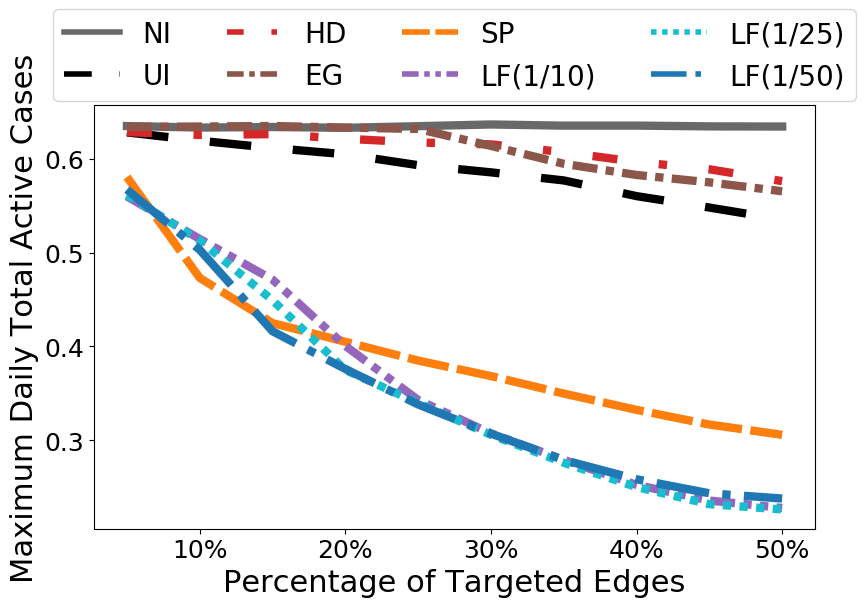

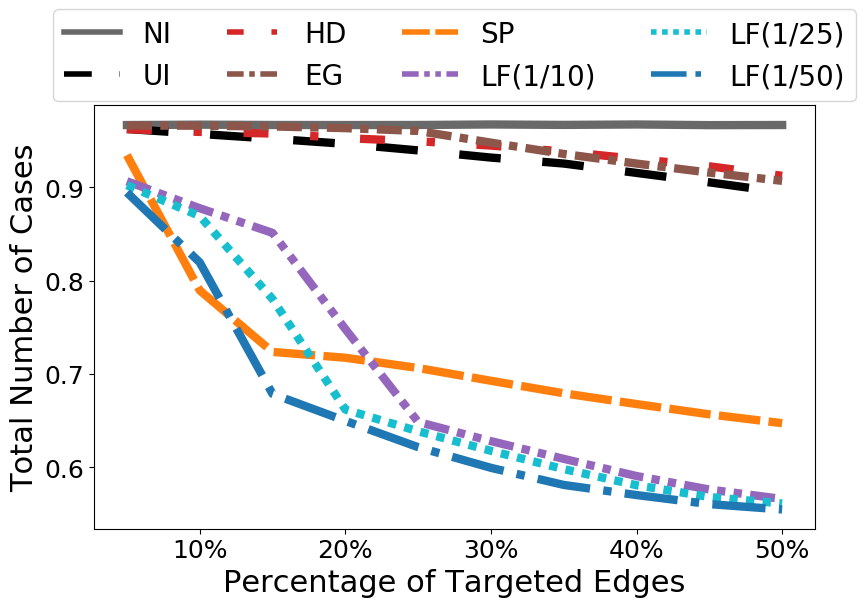

In [37]:
maxCases_ni_mean = vec(mean(maxCases_ni, dims=1))./n;
maxCases_ui_mean = vec(mean(maxCases_ui, dims=1))./n;
maxCases_hd_mean = vec(mean(maxCases_hd, dims=1))./n;
maxCases_eg_mean = vec(mean(maxCases_eg, dims=1))./n;
maxCases_sp_mean = vec(mean(maxCases_sp, dims=1))./n;
maxCases_lf10_mean = vec(mean(maxCases_lf10, dims=1))./n;
maxCases_lf04_mean = vec(mean(maxCases_lf04, dims=1))./n;
maxCases_lf02_mean = vec(mean(maxCases_lf02, dims=1))./n;
totalCases_ni_mean = vec(mean(totalCases_ni, dims=1))./n;
totalCases_ui_mean = vec(mean(totalCases_ui, dims=1))./n;
totalCases_hd_mean = vec(mean(totalCases_hd, dims=1))./n;
totalCases_eg_mean = vec(mean(totalCases_eg, dims=1))./n;
totalCases_sp_mean = vec(mean(totalCases_sp, dims=1))./n;
totalCases_lf10_mean = vec(mean(totalCases_lf10, dims=1))./n;
totalCases_lf04_mean = vec(mean(totalCases_lf04, dims=1))./n;
totalCases_lf02_mean = vec(mean(totalCases_lf02, dims=1))./n;

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=6)
plt.plot(target_perc, maxCases_lf04_mean, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Maximum Daily Total Active Cases",fontsize=22)
plt.savefig("montreal_epipeak_randinit_R035.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=6)
    plt.plot(target_perc, totalCases_lf04_mean, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Total Number of Cases",fontsize=22)
plt.savefig("montreal_episize_randinit_R035.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

### Simulation for interventions that start on day 5

In [38]:
reduced_weight = .1;
target_perc = Float64[5.0e-2,.1,.15,.2,.25,.3,.35,.4,.45,.5];
t_end = 100
t_delay = 5
t_con = t_end - t_delay

num_scenarios = length(target_perc);
num_trials = 20;

maxCases_ni = zeros(Int, (num_trials,num_scenarios));
maxCases_ui = zeros(Int, (num_trials,num_scenarios));
maxCases_hd = zeros(Int, (num_trials,num_scenarios));
maxCases_eg = zeros(Int, (num_trials,num_scenarios));
maxCases_sp = zeros(Int, (num_trials,num_scenarios));
maxCases_lf10 = zeros(Int, (num_trials,num_scenarios));
maxCases_lf04 = zeros(Int, (num_trials,num_scenarios));
maxCases_lf02 = zeros(Int, (num_trials,num_scenarios));
totalCases_ni = zeros(Int, (num_trials,num_scenarios));
totalCases_ui = zeros(Int, (num_trials,num_scenarios));
totalCases_hd = zeros(Int, (num_trials,num_scenarios));
totalCases_eg = zeros(Int, (num_trials,num_scenarios));
totalCases_sp = zeros(Int, (num_trials,num_scenarios));
totalCases_lf10 = zeros(Int, (num_trials,num_scenarios));
totalCases_lf04 = zeros(Int, (num_trials,num_scenarios));
totalCases_lf02 = zeros(Int, (num_trials,num_scenarios));

for k in 1:num_scenarios
    
    perc = target_perc[k];
    
    lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
    lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, descending=true, weight=reduced_weight);
    lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
    lw_sp = get_list_of_weights(ll, edges, sp, edge_to_loc, perc, weight=reduced_weight);
    lw_lf10 = get_list_of_weights(ll, edges, local10, edge_to_loc, perc, weight=reduced_weight);
    lw_lf04 = get_list_of_weights(ll, edges, local04, edge_to_loc, perc, weight=reduced_weight);
    lw_lf02 = get_list_of_weights(ll, edges, local02, edge_to_loc, perc, weight=reduced_weight);
    
    for trial in 1:num_trials
        
        @printf("\rperc %.2f \ttrial %d of %d ", perc, trial, num_trials)
        
        init_state, _, _, _, _ = Main.agentSEIR(ll, days=t_delay, beta=0.67);
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.67, rand_init=false, init_state=init_state);
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.67, weighted=true, lw=lw_ui, rand_init=false, init_state=init_state);
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.67, weighted=true, lw=lw_hd, rand_init=false, init_state=init_state);
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.67, weighted=true, lw=lw_eg, rand_init=false, init_state=init_state);
        _, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_con, beta=0.67, weighted=true, lw=lw_sp, rand_init=false, init_state=init_state);
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_con, beta=0.67, weighted=true, lw=lw_lf10, rand_init=false, init_state=init_state);
        _, _, sum_E_lf04, sum_I_lf04, sum_R_lf04 = Main.agentSEIR(ll, days=t_con, beta=0.67, weighted=true, lw=lw_lf04, rand_init=false, init_state=init_state);
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_con, beta=0.67, weighted=true, lw=lw_lf02, rand_init=false, init_state=init_state);
        
        maxCases_ni[trial,k] = maximum(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = maximum(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = maximum(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = maximum(sum_E_eg + sum_I_eg)
        maxCases_sp[trial,k] = maximum(sum_E_sp + sum_I_sp)
        maxCases_lf10[trial,k] = maximum(sum_E_lf10 + sum_I_lf10)
        maxCases_lf04[trial,k] = maximum(sum_E_lf04 + sum_I_lf04)
        maxCases_lf02[trial,k] = maximum(sum_E_lf02 + sum_I_lf02)   
        totalCases_ni[trial,k] = sum_R_ni[t_con+1]
        totalCases_ui[trial,k] = sum_R_ui[t_con+1]
        totalCases_hd[trial,k] = sum_R_hd[t_con+1]
        totalCases_eg[trial,k] = sum_R_eg[t_con+1]
        totalCases_sp[trial,k] = sum_R_sp[t_con+1]
        totalCases_lf10[trial,k] = sum_R_lf10[t_con+1]
        totalCases_lf04[trial,k] = sum_R_lf04[t_con+1]
        totalCases_lf02[trial,k] = sum_R_lf02[t_con+1]
    end
end

perc 0.50 	trial 20 of 20 0.15 	trial 2 of 20 0.15 	trial 4 of 20 0.15 	trial 6 of 20 0.15 	trial 8 of 20 0.15 	trial 10 of 20 0.15 	trial 12 of 20 0.15 	trial 14 of 20 0.15 	trial 16 of 20 0.15 	trial 18 of 20 0.15 	trial 20 of 20 0.25 	trial 2 of 20 0.25 	trial 4 of 20 0.25 	trial 6 of 20 0.25 	trial 8 of 20 0.25 	trial 10 of 20 0.25 	trial 12 of 20 0.25 	trial 14 of 20 0.25 	trial 16 of 20 0.25 	trial 18 of 20 0.25 	trial 20 of 20 0.35 	trial 2 of 20 0.35 	trial 4 of 20 0.35 	trial 6 of 20 0.35 	trial 8 of 20 0.35 	trial 10 of 20 0.35 	trial 12 of 20 0.35 	trial 14 of 20 0.35 	trial 16 of 20 0.35 	trial 18 of 20 0.35 	trial 20 of 20 0.45 	trial 2 of 20 0.45 	trial 4 of 20 0.45 	trial 6 of 20 0.45 	trial 8 of 20 0.45 	trial 10 of 20 0.45 	trial 12 of 20 0.45 	trial 14 of 20 0.45 	trial 16 of 20 0.45 	trial 18 of 20 0.45 	trial 20 of 20 

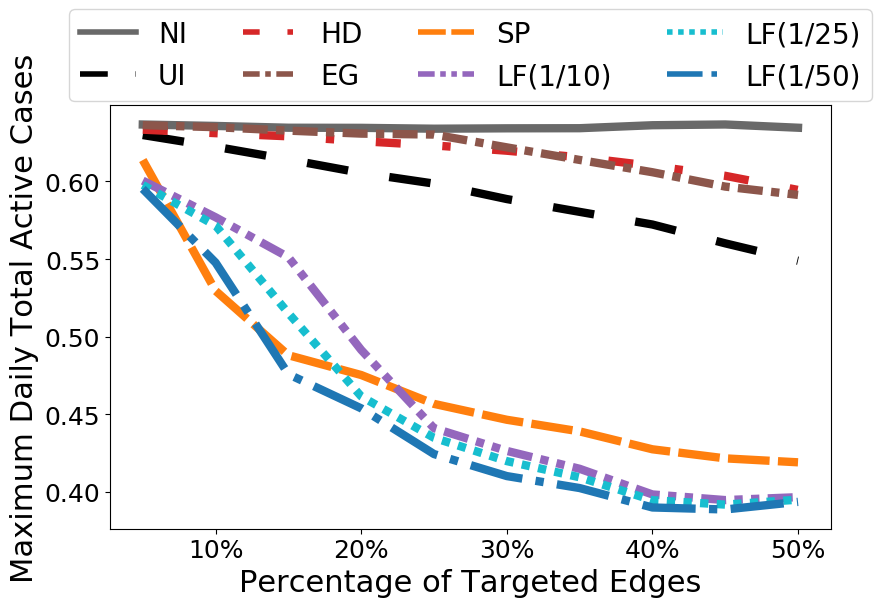

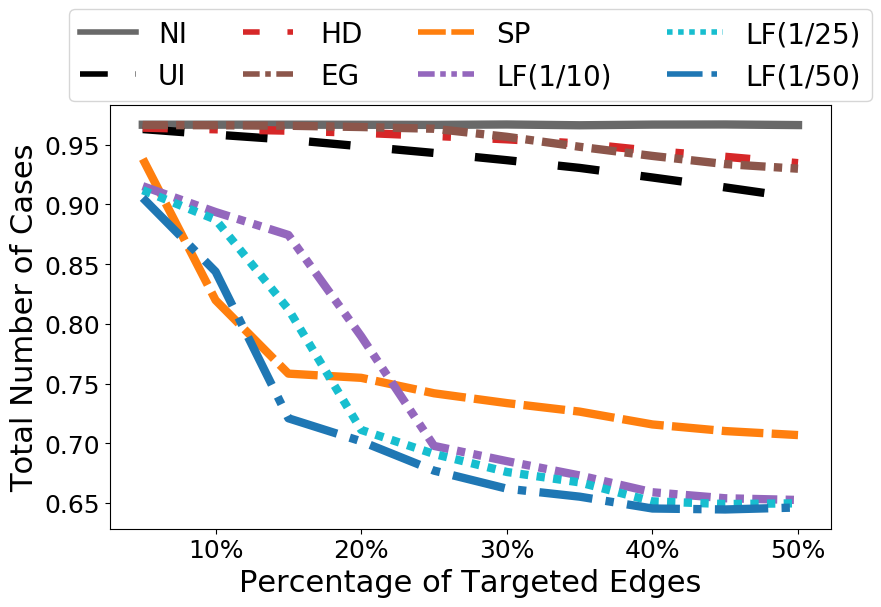

In [39]:
maxCases_ni_mean = vec(mean(maxCases_ni, dims=1))./n;
maxCases_ui_mean = vec(mean(maxCases_ui, dims=1))./n;
maxCases_hd_mean = vec(mean(maxCases_hd, dims=1))./n;
maxCases_eg_mean = vec(mean(maxCases_eg, dims=1))./n;
maxCases_sp_mean = vec(mean(maxCases_sp, dims=1))./n;
maxCases_lf10_mean = vec(mean(maxCases_lf10, dims=1))./n;
maxCases_lf04_mean = vec(mean(maxCases_lf04, dims=1))./n;
maxCases_lf02_mean = vec(mean(maxCases_lf02, dims=1))./n;
totalCases_ni_mean = vec(mean(totalCases_ni, dims=1))./n;
totalCases_ui_mean = vec(mean(totalCases_ui, dims=1))./n;
totalCases_hd_mean = vec(mean(totalCases_hd, dims=1))./n;
totalCases_eg_mean = vec(mean(totalCases_eg, dims=1))./n;
totalCases_sp_mean = vec(mean(totalCases_sp, dims=1))./n;
totalCases_lf10_mean = vec(mean(totalCases_lf10, dims=1))./n;
totalCases_lf04_mean = vec(mean(totalCases_lf04, dims=1))./n;
totalCases_lf02_mean = vec(mean(totalCases_lf02, dims=1))./n;

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=6)
plt.plot(target_perc, maxCases_lf04_mean, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Maximum Daily Total Active Cases",fontsize=22)
plt.savefig("montreal_epipeak_randinit_R035_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=6)
    plt.plot(target_perc, totalCases_lf04_mean, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Total Number of Cases",fontsize=22)
plt.savefig("montreal_episize_randinit_R035_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

## Scenario 4: $\beta$ is set to correspond to $R_0 = 4.5$

In [40]:
# Verify that beta is set appropriately
t_end = 100
_, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_end, beta=0.86)
println("This should be around 0.99: ", sum_R[t_end+1]/n)

This should be around 0.99: 0.9883297075175248


In [41]:
perc = .25;
reduced_weight = .1;

In [42]:
lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, descending=true, weight=reduced_weight);
lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
lw_sp = get_list_of_weights(ll, edges, sp, edge_to_loc, perc, weight=reduced_weight);
lw_lf10 = get_list_of_weights(ll, edges, local10, edge_to_loc, perc, weight=reduced_weight);
lw_lf04 = get_list_of_weights(ll, edges, local04, edge_to_loc, perc, weight=reduced_weight);
lw_lf02 = get_list_of_weights(ll, edges, local02, edge_to_loc, perc, weight=reduced_weight);

#### Predicted epidemic curves: random initialization, no delay, 25% intervention

In [43]:
t_end = 50

init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

_, sum_S_ni, sum_E_ni, sum_I_ni, sum_R_ni = agentSEIR(ll, days=t_end, beta=0.86, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_ui, sum_E_ui, sum_I_ui, sum_R_ui = agentSEIR(ll, days=t_end, beta=0.86, weighted=true, lw=lw_ui, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_hd, sum_E_hd, sum_I_hd, sum_R_hd = agentSEIR(ll, days=t_end, beta=0.86, weighted=true, lw=lw_hd, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_eg, sum_E_eg, sum_I_eg, sum_R_eg = agentSEIR(ll, days=t_end, beta=0.86, weighted=true, lw=lw_eg, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_sp, sum_E_sp, sum_I_sp, sum_R_sp = agentSEIR(ll, days=t_end, beta=0.86, weighted=true, lw=lw_sp, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_lf10, sum_E_lf10, sum_I_lf10, sum_R_lf10 = agentSEIR(ll, days=t_end, beta=0.86, weighted=true, lw=lw_lf10, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_lf04, sum_E_lf04, sum_I_lf04, sum_R_lf04 = agentSEIR(ll, days=t_end, beta=0.86, weighted=true, lw=lw_lf04, rand_init=false, init_infectious_nodes=init_rand_infectious);
_, sum_S_lf02, sum_E_lf02, sum_I_lf02, sum_R_lf02 = agentSEIR(ll, days=t_end, beta=0.86, weighted=true, lw=lw_lf02, rand_init=false, init_infectious_nodes=init_rand_infectious);

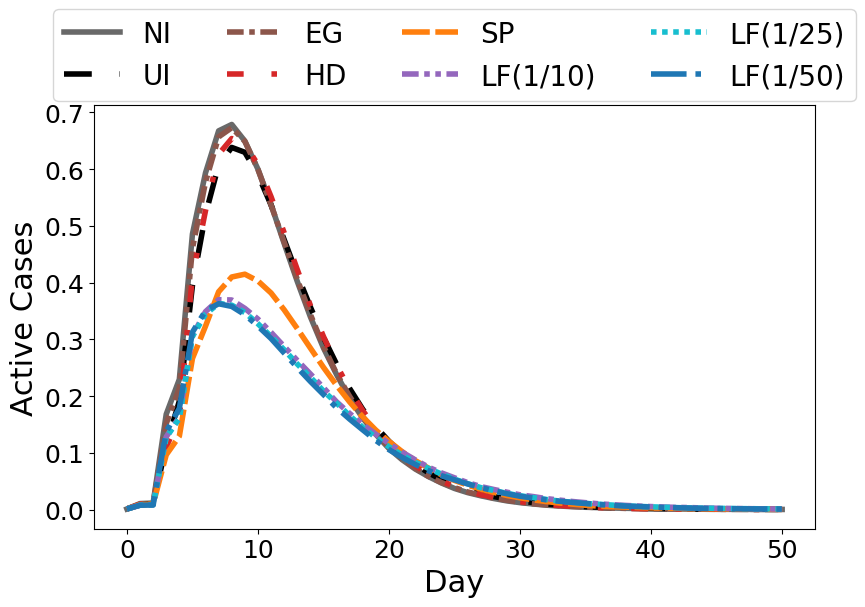

In [44]:
t_int = [i for i in 0:t_end]

plt.figure(figsize=(9.3,5.5))
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label="NI", linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label="UI", linestyle=(0,(5,5)), color="k", linewidth=4)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_sp+sum_I_sp)/n, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf10+sum_I_lf10)/n, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf04+sum_I_lf04)/n, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf02+sum_I_lf02)/n, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Day", fontsize=22)
plt.ylabel("Active Cases", fontsize=22)
plt.savefig("montreal_curves_randinit_R045.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

#### Predicted epidemic curves: random initialization, delay = 5 days, 25% intervention

In [45]:
t_end = 50
t_delay = 5
t_con = t_end - t_delay

init_state, sum_S, sum_E, sum_I, sum_R = Main.agentSEIR(ll, days=t_delay, beta=0.86);
_, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.86, rand_init=false, init_state=init_state);
_, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.86, weighted=true, lw=lw_ui, rand_init=false, init_state=init_state);
_, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.86, weighted=true, lw=lw_hd, rand_init=false, init_state=init_state);
_, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.86, weighted=true, lw=lw_eg, rand_init=false, init_state=init_state);
_, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_con, beta=0.86, weighted=true, lw=lw_sp, rand_init=false, init_state=init_state);
_, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_con, beta=0.86, weighted=true, lw=lw_lf10, rand_init=false, init_state=init_state);
_, _, sum_E_lf04, sum_I_lf04, sum_R_lf04 = Main.agentSEIR(ll, days=t_con, beta=0.86, weighted=true, lw=lw_lf04, rand_init=false, init_state=init_state);
_, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_con, beta=0.86, weighted=true, lw=lw_lf02, rand_init=false, init_state=init_state);

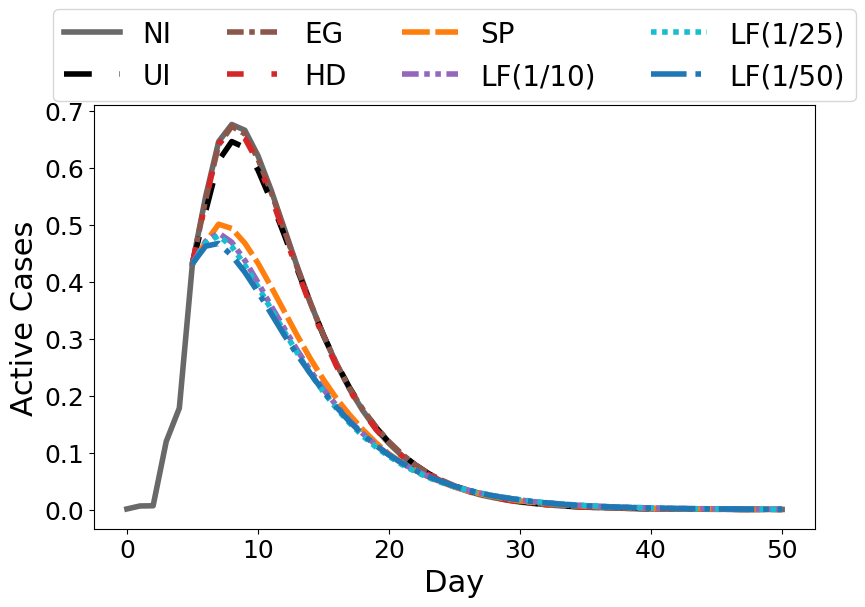

In [46]:
t_ini = [i for i in 0:t_delay]
t_int = [i for i in t_delay:t_end]

plt.figure(figsize=(9.3,5.5))
plt.plot(t_ini, (sum_E+sum_I)/n, linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ni+sum_I_ni)/n, label="NI", linestyle="-", color="dimgray", linewidth=4)
plt.plot(t_int, (sum_E_ui+sum_I_ui)/n, label="UI", linestyle=(0,(5,5)), color="k", linewidth=4)
plt.plot(t_int, (sum_E_eg+sum_I_eg)/n, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_hd+sum_I_hd)/n, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_sp+sum_I_sp)/n, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf10+sum_I_lf10)/n, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf04+sum_I_lf04)/n, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=4, alpha=1)
plt.plot(t_int, (sum_E_lf02+sum_I_lf02)/n, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=4, alpha=1)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Day", fontsize=22)
plt.ylabel("Active Cases", fontsize=22)
plt.savefig("montreal_curves_randinit_R045_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

### Simulation for interventions that start on day 0

In [47]:
reduced_weight = .1;
t_end = 100;
target_perc = Float64[5.0e-2,.1,.15,.2,.25,.3,.35,.4,.45,.5];

num_scenarios = length(target_perc);
num_trials = 20;

maxCases_ni = zeros(Int, (num_trials,num_scenarios));
maxCases_ui = zeros(Int, (num_trials,num_scenarios));
maxCases_hd = zeros(Int, (num_trials,num_scenarios));
maxCases_eg = zeros(Int, (num_trials,num_scenarios));
maxCases_sp = zeros(Int, (num_trials,num_scenarios));
maxCases_lf10 = zeros(Int, (num_trials,num_scenarios));
maxCases_lf04 = zeros(Int, (num_trials,num_scenarios));
maxCases_lf02 = zeros(Int, (num_trials,num_scenarios));
totalCases_ni = zeros(Int, (num_trials,num_scenarios));
totalCases_ui = zeros(Int, (num_trials,num_scenarios));
totalCases_hd = zeros(Int, (num_trials,num_scenarios));
totalCases_eg = zeros(Int, (num_trials,num_scenarios));
totalCases_sp = zeros(Int, (num_trials,num_scenarios));
totalCases_lf10 = zeros(Int, (num_trials,num_scenarios));
totalCases_lf04 = zeros(Int, (num_trials,num_scenarios));
totalCases_lf02 = zeros(Int, (num_trials,num_scenarios));

for k in 1:num_scenarios
    
    perc = target_perc[k];
    
    lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
    lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, descending=true, weight=reduced_weight);
    lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
    lw_sp = get_list_of_weights(ll, edges, sp, edge_to_loc, perc, weight=reduced_weight);
    lw_lf10 = get_list_of_weights(ll, edges, local10, edge_to_loc, perc, weight=reduced_weight);
    lw_lf04 = get_list_of_weights(ll, edges, local04, edge_to_loc, perc, weight=reduced_weight);
    lw_lf02 = get_list_of_weights(ll, edges, local02, edge_to_loc, perc, weight=reduced_weight);
    
    for trial in 1:num_trials
        
        @printf("\rperc %.2f \ttrial %d of %d ", perc, trial, num_trials)
        
        init_rand_infectious = rand(1:n, Int(ceil(0.001*n)))

        _, _, sum_E_ni, sum_I_ni, sum_R_ni = agentSEIR(ll, days=t_end, beta=0.86, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = agentSEIR(ll, days=t_end, beta=0.86, weighted=true, lw=lw_ui, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = agentSEIR(ll, days=t_end, beta=0.86, weighted=true, lw=lw_hd, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = agentSEIR(ll, days=t_end, beta=0.86, weighted=true, lw=lw_eg, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _p, sum_E_sp, sum_I_sp, sum_R_sp = agentSEIR(ll, days=t_end, beta=0.86, weighted=true, lw=lw_sp, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = agentSEIR(ll, days=t_end, beta=0.86, weighted=true, lw=lw_lf10, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_lf04, sum_I_lf04, sum_R_lf04 = agentSEIR(ll, days=t_end, beta=0.86, weighted=true, lw=lw_lf04, rand_init=false, init_infectious_nodes=init_rand_infectious);
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = agentSEIR(ll, days=t_end, beta=0.86, weighted=true, lw=lw_lf02, rand_init=false, init_infectious_nodes=init_rand_infectious);
        
        maxCases_ni[trial,k] = maximum(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = maximum(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = maximum(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = maximum(sum_E_eg + sum_I_eg)
        maxCases_sp[trial,k] = maximum(sum_E_sp + sum_I_sp)
        maxCases_lf10[trial,k] = maximum(sum_E_lf10 + sum_I_lf10)
        maxCases_lf04[trial,k] = maximum(sum_E_lf04 + sum_I_lf04)
        maxCases_lf02[trial,k] = maximum(sum_E_lf02 + sum_I_lf02)   
        totalCases_ni[trial,k] = sum_R_ni[t_end+1]
        totalCases_ui[trial,k] = sum_R_ui[t_end+1]
        totalCases_hd[trial,k] = sum_R_hd[t_end+1]
        totalCases_eg[trial,k] = sum_R_eg[t_end+1]
        totalCases_sp[trial,k] = sum_R_sp[t_end+1]
        totalCases_lf10[trial,k] = sum_R_lf10[t_end+1]
        totalCases_lf04[trial,k] = sum_R_lf04[t_end+1]
        totalCases_lf02[trial,k] = sum_R_lf02[t_end+1]
    end
end

perc 0.50 	trial 20 of 20 0.15 	trial 2 of 20 0.15 	trial 4 of 20 0.15 	trial 6 of 20 0.15 	trial 8 of 20 0.15 	trial 10 of 20 0.15 	trial 12 of 20 0.15 	trial 14 of 20 0.15 	trial 16 of 20 0.15 	trial 18 of 20 0.15 	trial 20 of 20 0.25 	trial 2 of 20 0.25 	trial 4 of 20 0.25 	trial 6 of 20 0.25 	trial 8 of 20 0.25 	trial 10 of 20 0.25 	trial 12 of 20 0.25 	trial 14 of 20 0.25 	trial 16 of 20 0.25 	trial 18 of 20 0.25 	trial 20 of 20 0.35 	trial 2 of 20 0.35 	trial 4 of 20 0.35 	trial 6 of 20 0.35 	trial 8 of 20 0.35 	trial 10 of 20 0.35 	trial 12 of 20 0.35 	trial 14 of 20 0.35 	trial 16 of 20 0.35 	trial 18 of 20 0.35 	trial 20 of 20 0.45 	trial 2 of 20 0.45 	trial 4 of 20 0.45 	trial 6 of 20 0.45 	trial 8 of 20 0.45 	trial 10 of 20 0.45 	trial 12 of 20 0.45 	trial 14 of 20 0.45 	trial 16 of 20 0.45 	trial 18 of 20 0.45 	trial 20 of 20 

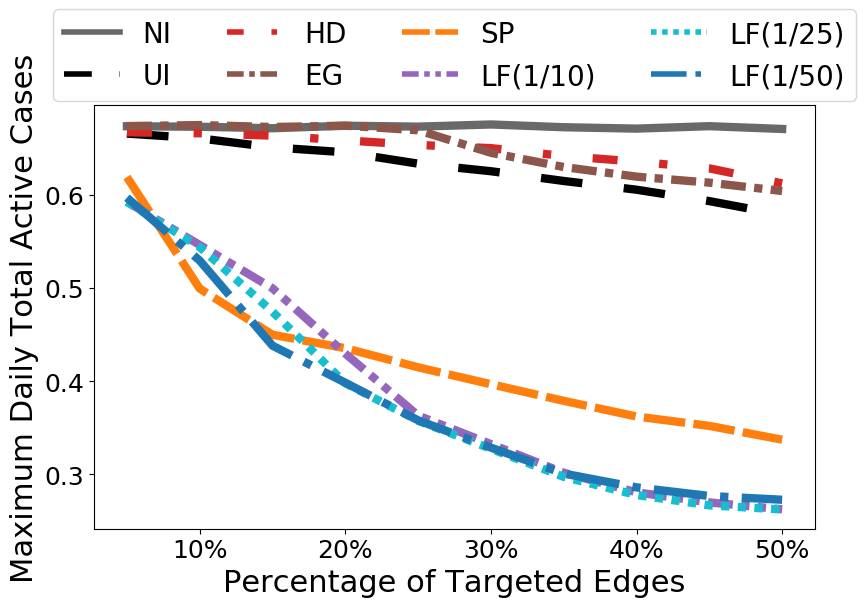

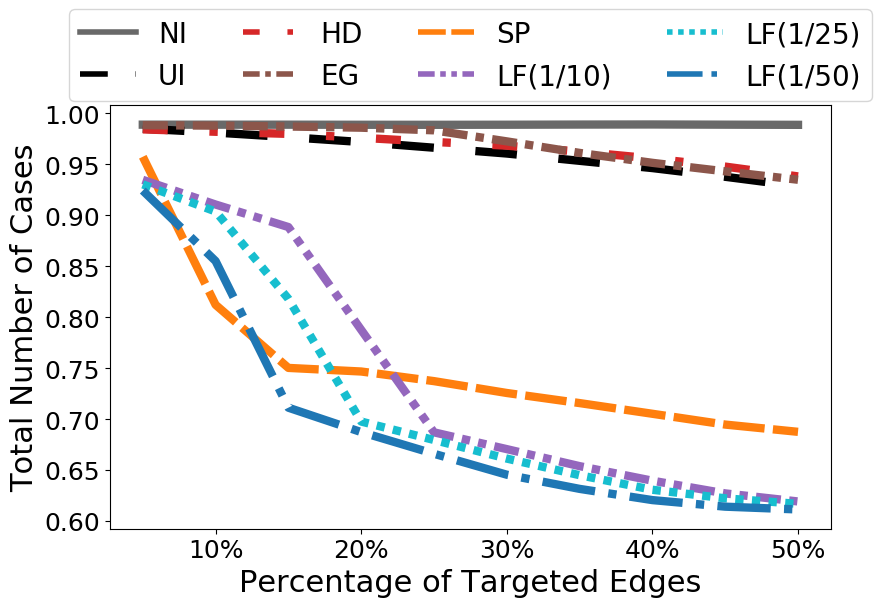

In [48]:
maxCases_ni_mean = vec(mean(maxCases_ni, dims=1))./n;
maxCases_ui_mean = vec(mean(maxCases_ui, dims=1))./n;
maxCases_hd_mean = vec(mean(maxCases_hd, dims=1))./n;
maxCases_eg_mean = vec(mean(maxCases_eg, dims=1))./n;
maxCases_sp_mean = vec(mean(maxCases_sp, dims=1))./n;
maxCases_lf10_mean = vec(mean(maxCases_lf10, dims=1))./n;
maxCases_lf04_mean = vec(mean(maxCases_lf04, dims=1))./n;
maxCases_lf02_mean = vec(mean(maxCases_lf02, dims=1))./n;
totalCases_ni_mean = vec(mean(totalCases_ni, dims=1))./n;
totalCases_ui_mean = vec(mean(totalCases_ui, dims=1))./n;
totalCases_hd_mean = vec(mean(totalCases_hd, dims=1))./n;
totalCases_eg_mean = vec(mean(totalCases_eg, dims=1))./n;
totalCases_sp_mean = vec(mean(totalCases_sp, dims=1))./n;
totalCases_lf10_mean = vec(mean(totalCases_lf10, dims=1))./n;
totalCases_lf04_mean = vec(mean(totalCases_lf04, dims=1))./n;
totalCases_lf02_mean = vec(mean(totalCases_lf02, dims=1))./n;

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=6)
plt.plot(target_perc, maxCases_lf04_mean, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Maximum Daily Total Active Cases",fontsize=22)
plt.savefig("montreal_epipeak_randinit_R045.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=6)
    plt.plot(target_perc, totalCases_lf04_mean, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Total Number of Cases",fontsize=22)
plt.savefig("montreal_episize_randinit_R045.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

### Simulation for interventions that start on day 5

In [49]:
reduced_weight = .1;
target_perc = Float64[5.0e-2,.1,.15,.2,.25,.3,.35,.4,.45,.5];
t_end = 100
t_delay = 5
t_con = t_end - t_delay

num_scenarios = length(target_perc);
num_trials = 20;

maxCases_ni = zeros(Int, (num_trials,num_scenarios));
maxCases_ui = zeros(Int, (num_trials,num_scenarios));
maxCases_hd = zeros(Int, (num_trials,num_scenarios));
maxCases_eg = zeros(Int, (num_trials,num_scenarios));
maxCases_sp = zeros(Int, (num_trials,num_scenarios));
maxCases_lf10 = zeros(Int, (num_trials,num_scenarios));
maxCases_lf04 = zeros(Int, (num_trials,num_scenarios));
maxCases_lf02 = zeros(Int, (num_trials,num_scenarios));
totalCases_ni = zeros(Int, (num_trials,num_scenarios));
totalCases_ui = zeros(Int, (num_trials,num_scenarios));
totalCases_hd = zeros(Int, (num_trials,num_scenarios));
totalCases_eg = zeros(Int, (num_trials,num_scenarios));
totalCases_sp = zeros(Int, (num_trials,num_scenarios));
totalCases_lf10 = zeros(Int, (num_trials,num_scenarios));
totalCases_lf04 = zeros(Int, (num_trials,num_scenarios));
totalCases_lf02 = zeros(Int, (num_trials,num_scenarios));

for k in 1:num_scenarios
    
    perc = target_perc[k];
    
    lw_ui = [ones(length(arr)).*(1.0-(1.0-reduced_weight)*perc) for arr in ll];
    lw_hd = get_list_of_weights_degree_dist(ll, edge_to_loc, perc, descending=true, weight=reduced_weight);
    lw_eg = get_list_of_weights_node_centrality(ll, eg, m, edge_to_loc, perc, weight=reduced_weight);
    lw_sp = get_list_of_weights(ll, edges, sp, edge_to_loc, perc, weight=reduced_weight);
    lw_lf10 = get_list_of_weights(ll, edges, local10, edge_to_loc, perc, weight=reduced_weight);
    lw_lf04 = get_list_of_weights(ll, edges, local04, edge_to_loc, perc, weight=reduced_weight);
    lw_lf02 = get_list_of_weights(ll, edges, local02, edge_to_loc, perc, weight=reduced_weight);
    
    for trial in 1:num_trials
        
        @printf("\rperc %.2f \ttrial %d of %d ", perc, trial, num_trials)
        
        init_state, _, _, _, _ = Main.agentSEIR(ll, days=t_delay, beta=0.86);
        _, _, sum_E_ni, sum_I_ni, sum_R_ni = Main.agentSEIR(ll, days=t_con, beta=0.86, rand_init=false, init_state=init_state);
        _, _, sum_E_ui, sum_I_ui, sum_R_ui = Main.agentSEIR(ll, days=t_con, beta=0.86, weighted=true, lw=lw_ui, rand_init=false, init_state=init_state);
        _, _, sum_E_hd, sum_I_hd, sum_R_hd = Main.agentSEIR(ll, days=t_con, beta=0.86, weighted=true, lw=lw_hd, rand_init=false, init_state=init_state);
        _, _, sum_E_eg, sum_I_eg, sum_R_eg = Main.agentSEIR(ll, days=t_con, beta=0.86, weighted=true, lw=lw_eg, rand_init=false, init_state=init_state);
        _, _, sum_E_sp, sum_I_sp, sum_R_sp = Main.agentSEIR(ll, days=t_con, beta=0.86, weighted=true, lw=lw_sp, rand_init=false, init_state=init_state);
        _, _, sum_E_lf10, sum_I_lf10, sum_R_lf10 = Main.agentSEIR(ll, days=t_con, beta=0.86, weighted=true, lw=lw_lf10, rand_init=false, init_state=init_state);
        _, _, sum_E_lf04, sum_I_lf04, sum_R_lf04 = Main.agentSEIR(ll, days=t_con, beta=0.86, weighted=true, lw=lw_lf04, rand_init=false, init_state=init_state);
        _, _, sum_E_lf02, sum_I_lf02, sum_R_lf02 = Main.agentSEIR(ll, days=t_con, beta=0.86, weighted=true, lw=lw_lf02, rand_init=false, init_state=init_state);
        
        maxCases_ni[trial,k] = maximum(sum_E_ni + sum_I_ni)
        maxCases_ui[trial,k] = maximum(sum_E_ui + sum_I_ui)
        maxCases_hd[trial,k] = maximum(sum_E_hd + sum_I_hd)
        maxCases_eg[trial,k] = maximum(sum_E_eg + sum_I_eg)
        maxCases_sp[trial,k] = maximum(sum_E_sp + sum_I_sp)
        maxCases_lf10[trial,k] = maximum(sum_E_lf10 + sum_I_lf10)
        maxCases_lf04[trial,k] = maximum(sum_E_lf04 + sum_I_lf04)
        maxCases_lf02[trial,k] = maximum(sum_E_lf02 + sum_I_lf02)   
        totalCases_ni[trial,k] = sum_R_ni[t_con+1]
        totalCases_ui[trial,k] = sum_R_ui[t_con+1]
        totalCases_hd[trial,k] = sum_R_hd[t_con+1]
        totalCases_eg[trial,k] = sum_R_eg[t_con+1]
        totalCases_sp[trial,k] = sum_R_sp[t_con+1]
        totalCases_lf10[trial,k] = sum_R_lf10[t_con+1]
        totalCases_lf04[trial,k] = sum_R_lf04[t_con+1]
        totalCases_lf02[trial,k] = sum_R_lf02[t_con+1]
    end
end

perc 0.50 	trial 20 of 20 0.15 	trial 2 of 20 0.15 	trial 4 of 20 0.15 	trial 6 of 20 0.15 	trial 8 of 20 0.15 	trial 10 of 20 0.15 	trial 12 of 20 0.15 	trial 14 of 20 0.15 	trial 16 of 20 0.15 	trial 18 of 20 0.15 	trial 20 of 20 0.25 	trial 2 of 20 0.25 	trial 4 of 20 0.25 	trial 6 of 20 0.25 	trial 8 of 20 0.25 	trial 10 of 20 0.25 	trial 12 of 20 0.25 	trial 14 of 20 0.25 	trial 16 of 20 0.25 	trial 18 of 20 0.25 	trial 20 of 20 0.35 	trial 2 of 20 0.35 	trial 4 of 20 0.35 	trial 6 of 20 0.35 	trial 8 of 20 0.35 	trial 10 of 20 0.35 	trial 12 of 20 0.35 	trial 14 of 20 0.35 	trial 16 of 20 0.35 	trial 18 of 20 0.35 	trial 20 of 20 0.45 	trial 2 of 20 0.45 	trial 4 of 20 0.45 	trial 6 of 20 0.45 	trial 8 of 20 0.45 	trial 10 of 20 0.45 	trial 12 of 20 0.45 	trial 14 of 20 0.45 	trial 16 of 20 0.45 	trial 18 of 20 0.45 	trial 20 of 20 

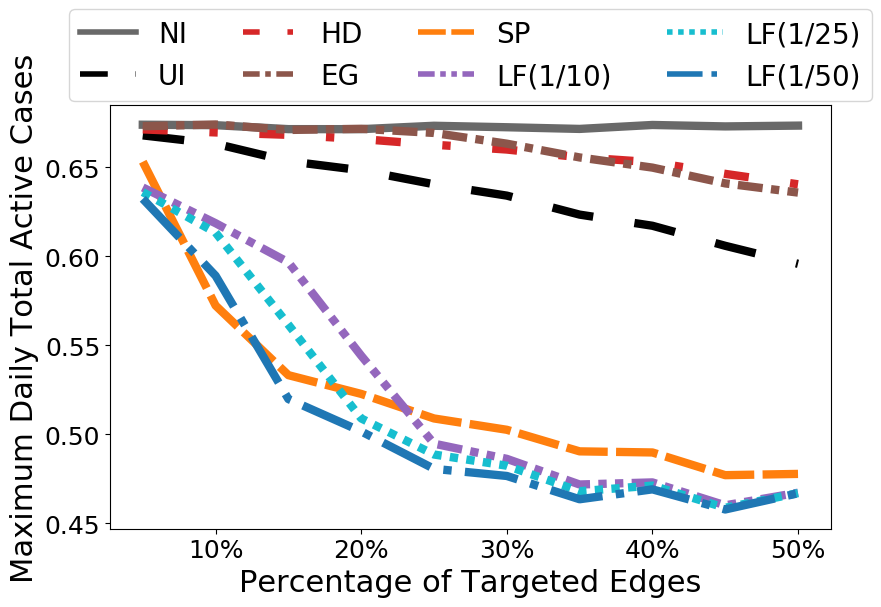

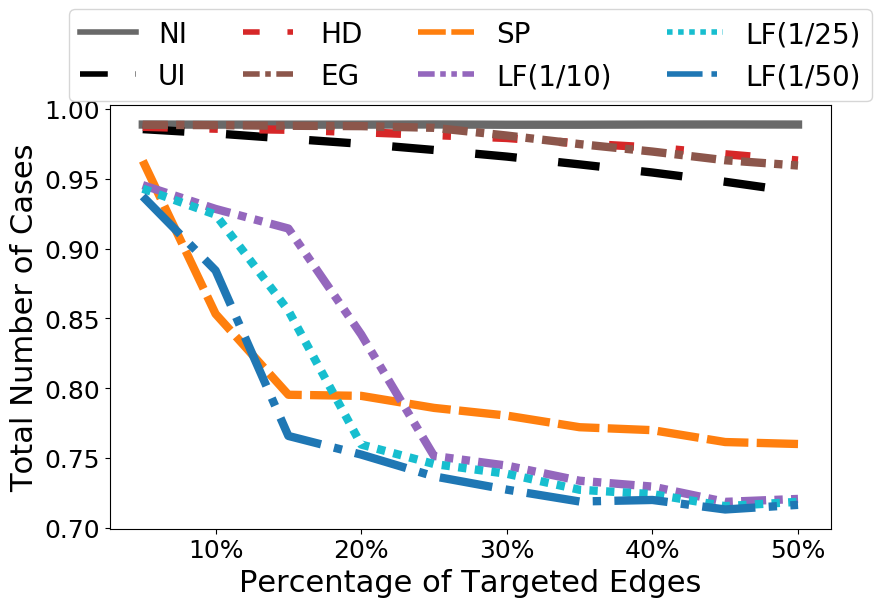

In [50]:
maxCases_ni_mean = vec(mean(maxCases_ni, dims=1))./n;
maxCases_ui_mean = vec(mean(maxCases_ui, dims=1))./n;
maxCases_hd_mean = vec(mean(maxCases_hd, dims=1))./n;
maxCases_eg_mean = vec(mean(maxCases_eg, dims=1))./n;
maxCases_sp_mean = vec(mean(maxCases_sp, dims=1))./n;
maxCases_lf10_mean = vec(mean(maxCases_lf10, dims=1))./n;
maxCases_lf04_mean = vec(mean(maxCases_lf04, dims=1))./n;
maxCases_lf02_mean = vec(mean(maxCases_lf02, dims=1))./n;
totalCases_ni_mean = vec(mean(totalCases_ni, dims=1))./n;
totalCases_ui_mean = vec(mean(totalCases_ui, dims=1))./n;
totalCases_hd_mean = vec(mean(totalCases_hd, dims=1))./n;
totalCases_eg_mean = vec(mean(totalCases_eg, dims=1))./n;
totalCases_sp_mean = vec(mean(totalCases_sp, dims=1))./n;
totalCases_lf10_mean = vec(mean(totalCases_lf10, dims=1))./n;
totalCases_lf04_mean = vec(mean(totalCases_lf04, dims=1))./n;
totalCases_lf02_mean = vec(mean(totalCases_lf02, dims=1))./n;

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, maxCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, maxCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, maxCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, maxCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, maxCases_sp_mean, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=6)
plt.plot(target_perc, maxCases_lf10_mean, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=6)
plt.plot(target_perc, maxCases_lf04_mean, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=6)
plt.plot(target_perc, maxCases_lf02_mean, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Maximum Daily Total Active Cases",fontsize=22)
plt.savefig("montreal_epipeak_randinit_R045_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()

plt.figure(figsize=(9.3,5.5))
plt.plot(target_perc, totalCases_ni_mean, label="NI", linestyle="-", color="dimgray", linewidth=6)
plt.plot(target_perc, totalCases_ui_mean, label="UI", linestyle=(0,(5,5)), color="k", linewidth=6)
plt.plot(target_perc, totalCases_hd_mean, label="HD", linestyle=(0,(3,5,1,5)), color="tab:red", linewidth=6)
plt.plot(target_perc, totalCases_eg_mean, label="EG", linestyle=(0,(3,1,1,1)), color="tab:brown", linewidth=6)
plt.plot(target_perc, totalCases_sp_mean, label="SP", linestyle=(0,(5,1)), color="tab:orange", linewidth=6)
plt.plot(target_perc, totalCases_lf10_mean, label="LF(1/10)", linestyle=(0,(3,1,1,1,1,1)), color="tab:purple", linewidth=6)
    plt.plot(target_perc, totalCases_lf04_mean, label="LF(1/25)", linestyle=(0,(1,1)), color="tab:cyan", linewidth=6)
plt.plot(target_perc, totalCases_lf02_mean, label="LF(1/50)", linestyle="dashdot", color="tab:blue", linewidth=6)
leg = plt.legend(fontsize=20, bbox_to_anchor=(.5, 1.26), ncol=4, loc="upper center", handlelength=2)
for i in leg.legendHandles
    i.set_linewidth(4)
end
plt.xticks((.1, .2, .3, .4, .5), ("10%", "20%", "30%", "40%", "50%"), color="k", size=18)
plt.yticks(size=18)
plt.xlabel("Percentage of Targeted Edges", fontsize=22)
plt.ylabel("Total Number of Cases",fontsize=22)
plt.savefig("montreal_episize_randinit_R045_delay5.png", bbox_inches="tight", format="png", dpi=400)
plt.show()